# Quantum Graph Hash (QGH_256)

***

## Concept Overview
Using **Classical Random Walks** + **Spectral Fingerprinting** using **Quantum Phase Estimation Algorithms**, we build a quantum hash function for cryptographic purposes.


## Methodology

### Process Flow Diagram (Conceptual)
The QGH process can be visualized as a three-stage pipeline:

1.  **Message induced Classical Walker** $\rightarrow$ **Weighted Graph** (4x4 grid, 16 nodes)
2.  **Weighted Graph** $\rightarrow$ **Spectral Fingerprint** (Used as Hash)


### 1. Classical Random Walks
*  A message-induced 2D walk is performed on a 4 by 4 grid, which generates and weights the edges of the resulting graph.
* A weighted graph representing the message's structure.

### 2. Quantum Phase Estimation (QPE)
* Matrix Exponentiation (with the help of trotter-decomposition) is used to convert the laplacian hermitian matrix into unitary
* QPE is used to extract the eigenvalue spectrum of the graph's Laplacian.
* We then use spectrums which construct the spectral fingerprints which serves as the hash.

***

### Authors
* **Mohana Priya Thinesh Kumar**
* **Pranavishvar Hariprakash**
* *IIT(ISM) Dhanbad*

In [21]:
!pip install qiskit[all] qiskit-aer qiskit-algorithms

In [22]:
from qiskit import *
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import ceil
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.quantum_info import Operator, SparsePauliOp
from scipy.linalg import expm, block_diag
from qiskit_algorithms import PhaseEstimation
from qiskit_aer.primitives import SamplerV2 as Sampler
from collections import Counter
from qiskit.synthesis import SuzukiTrotter
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from qiskit.primitives import StatevectorSampler
import pandas as pd
import time

**Message Induced Classical Walker**

In [40]:
def preprocessing(message: str, block_size: int):
    # Convert message into binary blocks of given size.
    message_bytes = message.encode("utf-8")
    binary_str = ''.join(format(byte, '08b') for byte in message_bytes)
    blocks = [binary_str[i:i + block_size] for i in range(0, len(binary_str), block_size)]
    if len(blocks[-1]) < block_size:
        blocks[-1] = blocks[-1].ljust(block_size, '0')
    return blocks

def move_walker(pos, direction, grid_size=4):
    # Move walker in toroidal (wrap-around) 4x4 grid.
    x, y = pos
    if direction == '00':      # down
        y = (y - 1) % grid_size
    elif direction == '01':    # up
        y = (y + 1) % grid_size
    elif direction == '10':    # right
        x = (x + 1) % grid_size
    elif direction == '11':    # left
        x = (x - 1) % grid_size
    return (x, y)

def walk(message: str):
    # Perform quantum-style walk over 4x4 grid using binary-encoded message.
    grid_size = 4
    block_size = 2
    blocks = preprocessing(message, block_size)

    # Build toroidal grid
    G = nx.grid_2d_graph(grid_size, grid_size, periodic=True)
    nx.set_edge_attributes(G, 0, "weight")

    pos = (grid_size // 2, grid_size // 2)  # start center
    path = [pos]

    for block in blocks:
        new_pos = move_walker(pos, block, grid_size)
        if G.has_edge(pos, new_pos):
            G[pos][new_pos]['weight'] += 1
        path.append(new_pos)
        pos = new_pos

    # Visualization
    plt.figure(figsize=(5, 5))
    pos_coords = {(x, y): (x, y) for x, y in G.nodes()}

    # Draw grid
    nx.draw(G, pos_coords, node_size=150, node_color='lightblue', edge_color='lightgray')

    # Highlight edges with nonzero weights
    nonzero_edges = [(u, v) for u, v in G.edges() if G[u][v]['weight'] > 0]
    edge_colors = [G[u][v]['weight'] for u, v in nonzero_edges]
    nx.draw_networkx_edges(G, pos_coords, edgelist=nonzero_edges,
                           edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=[1.5 + w for w in edge_colors])

    # Draw red path
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos_coords, edgelist=path_edges, edge_color='red', width=2)

    plt.title(f"Walker Path (Toroidal {grid_size}×{grid_size} Grid)")
    plt.axis('off')
    plt.show()

    return G, path



**Spectral Fingerprinting using Quantum Phase Estimation**

In [24]:
def extract_phases(counts, num_ancilla, t):
    phase_counts = Counter()
    for bitstring, count in counts.items():
        phase_bits = bitstring[:6]
        decimal = int(phase_bits, 2)
        phase = decimal / (2 ** num_ancilla)
        phase = 2*np.pi*phase/t
        phase_counts[phase] += count
    return phase_counts

In [41]:
def spectral_fingerprint(msg):
  G, path = walk(msg)

  heat_vectors = {}
  spectrum_collection = []
  n = len(G.nodes())

  A = nx.to_numpy_array(G)

  degrees = dict(G.degree())
  D = np.diag([degrees[node] for node in G.nodes()])
  L = D - A

  # Padding to next power of 2
  n_laplacian = L.shape[0]
  n_qubits = ceil(np.log2(n_laplacian))
  L_padded = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
  L_padded[:n_laplacian, :n_laplacian] = L

  # Normalize to [0, 1]
  L_min, L_max = L_padded.min(), L_padded.max()
  L_padded = (L_padded - L_min) / (L_max - L_min)



  pauli_op = SparsePauliOp.from_operator(Operator(L_padded).data)

  # Define times
  times = np.array(range(1, 5))*np.pi/5  # t1, t2, t3 t4
  # Generate Trotterized circuits
  trotter_circuits = {}
  unitary_gates = {}
  for t in times:
      evo_gate = PauliEvolutionGate(pauli_op, time=t, synthesis=SuzukiTrotter(order=2, reps=3))
      trotter_circuits[t] = evo_gate
      unitary_gates[t] = UnitaryGate(Operator(evo_gate).data, label=f"U({t})")

  superposition_state = np.zeros(2**n_qubits)
  for i in range(n):
    superposition_state[i] = 1
  superposition_state /= np.linalg.norm(superposition_state)

  spectrum = {}
  for t, unitary in unitary_gates.items():
    num_ancilla = 3
    initial_state = QuantumCircuit(n_qubits)
    initial_state.initialize(superposition_state)

    phase_estimation = PhaseEstimation(num_evaluation_qubits=num_ancilla, sampler=Sampler())
    simulator = Aer.get_backend("aer_simulator_statevector")
    circ = phase_estimation.construct_circuit(unitary, initial_state)
    circ.measure_all()
    transpiled = transpile(circ, simulator)
    job = simulator.run(transpiled, shots = 300, seed_simulator = 42)
    result = job.result()
    counts = result.get_counts()
    spectrum[t] = counts

  spectrum_collection.append(spectrum)

  heat_trace_vector = []

  for t, counts in spectrum.items():
    phases = extract_phases(counts, num_ancilla, t)
    heat_trace = np.average(np.exp(-t*np.array(list(phases.keys()))), weights=list(phases.values()))
    heat_trace_vector.append(heat_trace)

  heat_trace_vector = np.array(heat_trace_vector)
  heat_vectors[tuple(G.edges)] = heat_trace_vector

  for key, val in heat_vectors.items():
    return val

**Converting Spectral Fingerprint (Hash) into Bit String**

In [26]:
def convert_spectral_fingerprint_into_hash(spectral_fingerprint):
  bit_strings = [''.join(f'{b:08b}' for b in np.frombuffer(v.tobytes(), dtype=np.uint8)[::-1]) for v in spectral_fingerprint]
  bit_string = ''.join(bit_strings)

  return bit_string

**Testing for collision, avalanche**

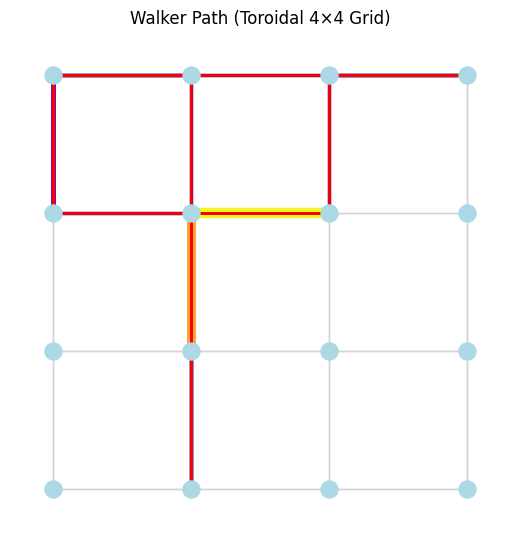

Hash: 0011111110101101001111101011111010101001001101001000111010110000001111111010010101010010111001011001011001001011001011111001101000111111101000100001011001111111110010010010100111001100010101010011111110001011101010111001010011110100110010000001100000001010


In [29]:
sf1 = spectral_fingerprint("hello")
hash1 = convert_spectral_fingerprint_into_hash(sf1)
print("Hash:",hash1)

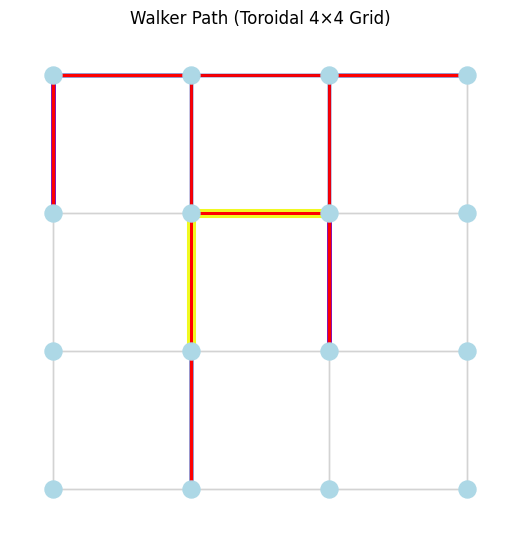

Hash: 0011111110010001110110110010100001000001100111010101010101000010001111111001010110010010010000100101110010001001101110001101110000111111100111001010011010111111110100010010100000100010000011100011111101111010111111110001111010110010111001101001111001001011


In [30]:
sf2 = spectral_fingerprint("hella")
hash2 = convert_spectral_fingerprint_into_hash(sf2)
print("Hash:", hash2)

**Collision Resistance Test**

In [31]:
# Test 1: Collision resistance
print(f"Collision: {hash1 == hash2}")

Collision: False


**Avalanche Test**

In [32]:
def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

# Test 2: Avalanche effect
dist = hamming_distance(hash1, hash2)
print(f"Hamming distance (avalanche): {dist} / {len(hash1)}")

Hamming distance (avalanche): 103 / 256


**Messages of different lengths**

In [33]:
msg87  = "Quantum hashing provides a way to compress classical data into a unique quantum fingerprint. Unlike classical hashing, where collisions may occur, quantum constructions leverage phase encoding, superposition, and interference to enhance unpredictability. The ordering of gates, especially the balance between diagonal (phase) and non-diagonal (mixing) operations, plays a crucial role. By measuring only at the very end, we ensure determinism in the output while preserving the collapsing property of the hash. This makes the design potentially useful for post-quantum cryptography, where both speed and security are essential"
msg200 = "Khaled Hosseini’s novel A Thousand Splendid Suns (published in 2007) tells the story of 2 women—Mariam and Laila—whose lives intersect in war-torn Afghanistan. Mariam, called a “harami” (illegitimate child), grows up carrying shame. At 15, she is forced into marriage with Rasheed, a much older shoemaker in Kabul. Laila, born later, enjoys school, laughter, and hope until civil war (1992-1996) destroys her family. Circumstances push her into Rasheed’s household, where she meets Mariam. At first, mistrust grows between them, but over time, their suffering under Rasheed’s cruelty transforms into deep loyalty. Together, they raise Laila’s children, share secret joys, and resist oppression. The novel blends tragedy with moments of fragile beauty: a game of cards, stolen laughter, or the sight of Kabul’s mountains glowing “like a thousand splendid suns.” Hosseini illustrates how love, sacrifice, and resilience outlast even brutality. Symbols of hope appear everywhere—sunlight, small kindnesses, even the memory of poetry. Ultimately, Mariam’s sacrifice ensures Laila’s survival, leaving readers with themes of endurance, justice, and redemption. This story is not just about Afghanistan, but about universal strength. It reminds us: humanity, even in ruins, can shine brighter than fear, proving that survival = love + courage + memory."
msg500 = "V. E. Schwab’s The Invisible Life of Addie LaRue (published in 2020) is a hauntingly beautiful novel that explores memory, identity, freedom, and the cost of choices. It begins in 1714, when a young French woman named Adeline LaRue makes a desperate bargain with a mysterious god of darkness. She wishes to escape marriage, small-town life, and the confines of time. The deal grants her immortality but with a cruel twist: everyone she meets forgets her the moment she leaves their sight. Her family forgets, friends forget, strangers forget, even people who spoke with her seconds before lose all recollection. Addie becomes invisible not in body, but in memory—forever untethered, a ghost walking through centuries. This curse seems like freedom at first, but it quickly transforms into a prison of loneliness. Addie learns to survive by stealing, manipulating, and drifting, yet she also learns how to experience art, ideas, and the world without attachments. She becomes a muse to artists who never remember her name but capture her presence in paintings, songs, and sketches. Across decades and wars, she adapts, learns languages, crosses oceans, and continues living, unseen yet unforgettable in traces. The curse endures until, in New York City in 2014, she meets Henry Strauss, a young man with his own secret: he remembers her. For the first time in 300 years, someone speaks her name and does not forget. This single recognition changes everything. Their relationship grows tender but fragile, as Henry’s deal with the same dark god (Luc, the entity who cursed Addie) comes with its own tragic price. Themes of love, mortality, sacrifice, and art echo throughout the story. Addie’s immortal journey poses questions: Is a life meaningful if no one remembers it? Does survival alone count as victory? The book suggests that memory lives not only in people, but also in stories, images, and creations. In fact, Addie finds ways to leave “marks” in the world, inspiring works of art, hinting that forgetting is never absolute. Schwab weaves lyrical prose with timelines that shift between Addie’s past (France, 18th–20th centuries) and her present in modern New York. The structure mirrors Addie’s fragmented existence—moments, flashes, impressions rather than continuity. Symbolism runs deep: shadows represent temptation, stars symbolize hope, and art becomes a vessel for immortality. The character of Luc embodies charm, cruelty, and inevitability, a dark counterpart to Addie’s stubborn resilience. The ending leaves readers with bittersweet resolution: Addie accepts her fate yet continues fighting for agency, even turning her curse into a form of rebellion. Ultimately, The Invisible Life of Addie LaRue resonates because it touches universal fears—being forgotten, being powerless, being voiceless—and counters them with the equally universal desires to love, to create, and to be remembered. Numbers, dates, and symbols anchor the novel’s themes: 1714 → the year the bargain begins, 2014 → the year Henry remembers, infinity (∞) → the curse’s endless weight, memory = meaning. The story whispers that even if names vanish, the essence of a life can shine like hidden constellations: faint, enduring, unforgettable."
msg1000 = "Leigh Bardugo’s Six of Crows (2015) is a fast-paced fantasy heist novel set in the bustling, gritty port city of Ketterdam, a place where trade = power, crime = opportunity, and loyalty is as fragile as glass. The story revolves around 6 very different characters: Kaz Brekker (mastermind, known as “Dirtyhands”), Inej Ghafa (the Wraith, agile and silent), Jesper Fahey (a sharpshooter with a gambling habit), Nina Zenik (a Heartrender Grisha with charm + wit), Matthias Helvar (a former soldier torn between faith and betrayal), and Wylan Van Eck (a demolition expert and runaway merchant’s son). Together, they form an unlikely crew hired to perform the impossible: break into the Ice Court, a supposedly impenetrable fortress in Fjerda, to retrieve a scientist who has developed a dangerous drug, jurda parem. This substance amplifies Grisha powers to godlike levels, but at the cost of addiction, madness, and death. Whoever controls jurda parem could dominate nations. The crew’s mission is worth 30 million kruge, a fortune that could buy freedom, revenge, or redemption—depending on who is holding the prize. Kaz Brekker, at only 17 years old, embodies ruthless calculation. He limps with a cane, wears gloves to hide scars, and trusts almost no one, yet he inspires loyalty through sheer willpower. His reputation in the Barrel (Ketterdam’s criminal district) is built on fear, strategy, and the myth that Kaz always has a plan B, C, and D. Inej, stolen from her family and forced into indenture, becomes Kaz’s most trusted spy. She moves like smoke, climbing walls, vanishing into shadows, gathering secrets; her faith and quiet strength ground the team. Jesper adds comic relief, yet beneath the jokes and quick draws is insecurity: debts, lies, and the gnawing weight of secrets. Nina and Matthias embody a central tension: Grisha magic versus Fjerdan fanaticism. Nina is bold, funny, and powerful; Matthias is stern, conflicted, and taught to hate everything Nina represents. Their dynamic weaves romance, betrayal, and reconciliation. Wylan, initially underestimated, proves his genius with demolitions, maps, and quiet courage. Each character has a backstory revealed piece by piece, deepening emotional stakes. Bardugo structures the novel like a chessboard: alternating points of view, overlapping plans, surprises, betrayals, reversals. The Ice Court heist is not a single event but a layered puzzle: infiltrating the city, smuggling in disguises, navigating double-crosses, climbing walls, unlocking impossible locks, surviving ambushes, and adapting when every plan collapses. Tension rises because failure means death, not just for the crew, but potentially for all Grisha if jurda parem spreads. Themes ripple across the story: trust vs betrayal, freedom vs control, revenge vs redemption, survival vs sacrifice. Money motivates, but so does trauma, longing, and love. Symbols recur: Kaz’s crow-headed cane = power and pain, Inej’s knives = faith and protection, Jesper’s guns = skill + recklessness, Nina’s waffles = humor + comfort, Matthias’s wolf imagery = inner conflict, Wylan’s drawings = fragile hope. The prose is sharp, mixing street slang, humor, and lyrical lines. Example: “No mourners, no funerals”—the crew’s saying—encapsulates gallows humor, acceptance of risk, and solidarity. Bardugo’s Grishaverse world-building includes layered cultures (Kerch merchants, Fjerdan warriors, Ravkan Grisha, Shu scientists, Zemeni traders). Each culture adds conflict, history, and flavor: trade routes, religious tensions, political corruption, racism, and greed. The Ice Court represents both the literal fortress and the metaphorical walls between people. The book is not just fantasy adventure; it’s commentary on exploitation, addiction, prejudice, and resilience. Characters chase kruge ($$), but what they truly crave is belonging, forgiveness, and freedom. Kaz hides grief for his brother Jordie, killed in a plague scam; Inej longs to buy back her family’s ship; Jesper hides his Grisha identity; Nina seeks atonement; Matthias wrestles with loyalty; Wylan fights to escape his father’s shadow. Their flaws make them real, their growth makes them unforgettable. The novel ends not with victory but with a cliffhanger: though the heist succeeds in part, betrayal shifts the balance. Wylan’s father, Jan Van Eck, double-crosses the crew, kidnapping Inej and stealing their bargaining chip. The kruge is denied, trust is fractured, and the stage is set for Crooked Kingdom (the sequel, 2016). Readers close the book not with relief but with urgency: What comes next? The rhythm of the story mimics a heartbeat: quiet reflection, sudden danger, laughter, violence, love, and fear all pulsing together. Every detail matters: a rope, a coin, a glance, a map, a promise. Bardugo creates a world where survival depends on noticing the unseen. Numbers (6 crows, 30 million kruge, 1 impossible job) drive the narrative, but emotions (love, grief, rage, hope) give it soul. Symbols embed math-like logic into art: Plan A → fail → Plan B → collapse → Plan C → adapt → survive. Equations echo: team = strength + flaws; heist = chaos + planning; freedom = risk × sacrifice; revenge ≠ peace. In Ketterdam, trust is currency, betrayal is inevitable, yet bonds form anyway. The crow motif repeats: clever, dark, communal, survivors. By the end, readers see not just criminals, but broken teenagers fighting for meaning. Six of Crows works as both entertainment and allegory: about found family, trauma, capitalism’s cruelty, and the stubborn refusal to be defined by the past. It asks: Can six flawed people outwit a world built to destroy them? Answer: maybe not forever, but long enough to carve their mark. Even if forgotten, even if betrayed, they prove survival = defiance. And that is why Bardugo’s novel endures: not only as a thrilling heist, but as a testament that in the shadows of greed and violence, hope still flies—black-winged, sharp-eyed, indomitable, like a crow rising against the storm."
msg2_1000="Cinder by Marissa Meyer is a captivating, futuristic retelling of the classic Cinderella story, set in a post–Fourth World War world where humans, cyborgs, and androids coexist in an uneasy balance amid technological marvels and political unrest. The novel takes place in New Beijing, the capital of the Eastern Commonwealth, a city that thrives with neon markets, bustling trade, and a mix of traditional culture and advanced machinery, yet remains shadowed by disease, inequality, and interplanetary tension. The protagonist, Linh Cinder, is a gifted young mechanic whose skills with machines make her indispensable to her community, but her life is constrained by one devastating secret—she is a cyborg, part human and part machine, a status that relegates her to the bottom of society’s hierarchy. Orphaned as a child and adopted by a man who later died, Cinder is left in the care of her cruel stepmother Adri and two stepsisters, Peony and Pearl. While Peony treats her with kindness, Adri despises her, viewing her mechanical parts as a stain on the family’s reputation. Cinder works tirelessly in her marketplace booth repairing androids, hovercrafts, and mechanical limbs, her hands blackened with grease, her wit sharp and guarded, all while dreaming of earning enough money to escape her suffocating home life. The world Meyer constructs is rich in detail and layered with tension: the Letumosis plague, a mysterious and incurable disease, ravages the population, killing indiscriminately and heightening social despair. Entire sectors are quarantined, scientists scramble for answers, and cyborgs—viewed as expendable—are often drafted for lethal medical experiments under the guise of public service. Above Earth looms another, more sinister force: the Lunars, a powerful civilization living on the Moon, ruled by the manipulative and tyrannical Queen Levana. The Lunars possess a bioelectrical gift that allows them to influence minds, control perceptions, and weave illusions so convincing they can make others see beauty or terror at will. Levana’s ambitions for domination, coupled with her willingness to manipulate and murder to achieve political gain, make her an ever-present threat to the fragile peace between Earth and Luna. In this volatile world, Cinder’s path unexpectedly crosses that of Prince Kai, the charming and idealistic heir to the Eastern Commonwealth’s throne. When the prince visits her booth incognito to have his broken android repaired, a spark of connection is lit between them—though neither fully understands the consequences that meeting will bring. Kai is struggling under immense pressure: his father, Emperor Rikan, is gravely ill with Letumosis, and the political council is urging him to consider an alliance with Queen Levana through marriage to secure peace. As Cinder and Kai’s lives intertwine, secrets unravel that threaten to upend the foundations of their world. Cinder’s own past, long buried beneath layers of mechanical parts and suppressed memories, begins to resurface through fragments and revelations that suggest she is far more than she appears. Her life becomes a collision of destiny and defiance as she learns that her existence may hold the key to humanity’s survival against the Lunar threat. Meyer’s reimagining of Cinderella is both faithful in spirit and boldly original in execution: the ball gown becomes a disguise for rebellion, the glass slipper a metal foot left behind in a desperate flight from discovery, and the fairy godmother’s magic is replaced by grit, intelligence, and mechanical ingenuity. Yet beneath the science fiction trappings, the emotional core of the fairy tale remains—the yearning for freedom, belonging, and identity in a world that seeks to define one’s worth by appearance and status. Through Cinder, Meyer explores what it means to be human in an age of machines. The protagonist’s mechanical body is a metaphor for societal otherness, and her struggle for autonomy mirrors the plight of anyone marginalized by the systems around them. Despite her prosthetic limbs and neural interface, Cinder’s humanity shines through her empathy, humor, and courage. She is a survivor in every sense—resourceful, intelligent, and compassionate even when the world treats her as disposable. Her friendship with her android companion Iko adds warmth and levity to the story; Iko, programmed with a “malfunctioning” personality chip that makes her flirtatious and funny, serves as a reminder that consciousness and emotion can exist even within artificial beings. Meyer’s characterization is one of the novel’s greatest strengths: Prince Kai is not a one-dimensional prince charming, but a young man burdened by leadership and moral conflict, forced to make impossible decisions between love, duty, and diplomacy. His interactions with Cinder are tender yet charged with tension, especially as secrets about her identity come to light. Supporting figures like Dr. Erland, the eccentric royal scientist, introduce layers of mystery and revelation—he becomes both a mentor and a symbol of the ethical dilemmas faced by those who manipulate biology and technology in pursuit of truth. The novel’s pacing is brisk, alternating between personal drama, political intrigue, and bursts of action that keep the reader fully engaged. The atmosphere of New Beijing feels alive: street vendors shouting, androids bustling, maglev trams gliding through smog-laced air—all vividly rendered in Meyer’s clean, cinematic prose. Underneath this futuristic setting, however, lie timeless themes: class discrimination, identity, sacrifice, and the moral cost of progress. The plague serves as both a literal and metaphorical disease—an emblem of societal decay and the fear that drives humans to cruelty when faced with uncertainty. The contrast between Earth’s technological vulnerability and Luna’s manipulative powers underscores a larger philosophical question: is control over others through illusion worse than the dehumanization of mechanical augmentation? Meyer refuses to offer easy answers, allowing the tension between freedom and conformity to remain unresolved. As the story builds toward its climax—the royal ball and the exposure of Cinder’s secret identity—the stakes reach their peak. When Cinder’s mechanical foot is revealed in front of the entire court, the familiar fairy-tale humiliation transforms into a moment of both horror and liberation: her secret is out, but so too is her strength. In the aftermath, she becomes a fugitive, hunted by those who would use her for power, and by those who fear what she represents. The novel closes not with a neat resolution, but with a sense of awakening: Cinder, bruised and broken yet unbowed, vows to fight back, setting the stage for the expansive journey that unfolds in later books of The Lunar Chronicles. Ultimately, Cinder succeeds not only as a retelling but as a story in its own right—a vibrant fusion of fairy tale, science fiction, and social commentary. It asks readers to consider the nature of humanity in a mechanized age, the cost of prejudice, and the courage it takes to rewrite one’s destiny. Through its blend of romance, rebellion, and futuristic imagination, Cinder stands as both an homage to classic storytelling and a manifesto for modern resilience, reminding us that even in a world of circuits and shadows, the human heart remains the strongest engine of all. "

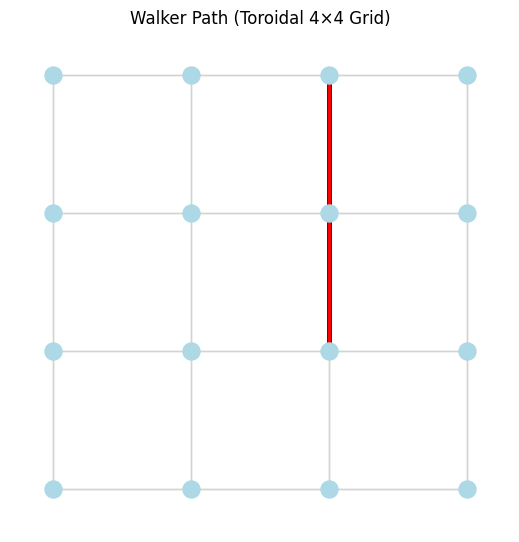

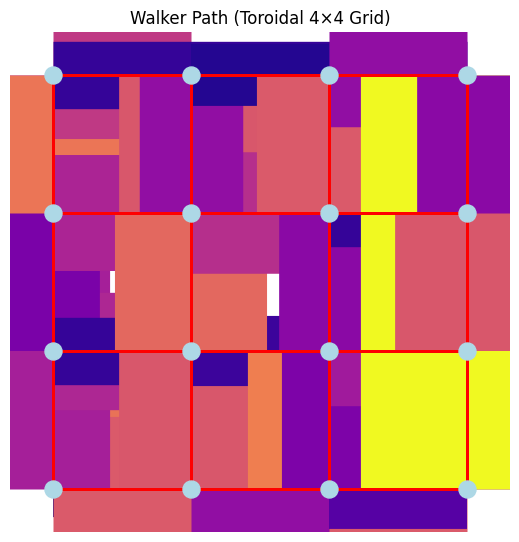

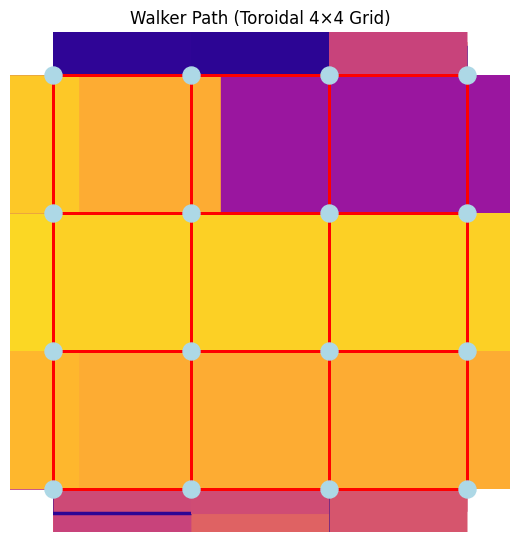

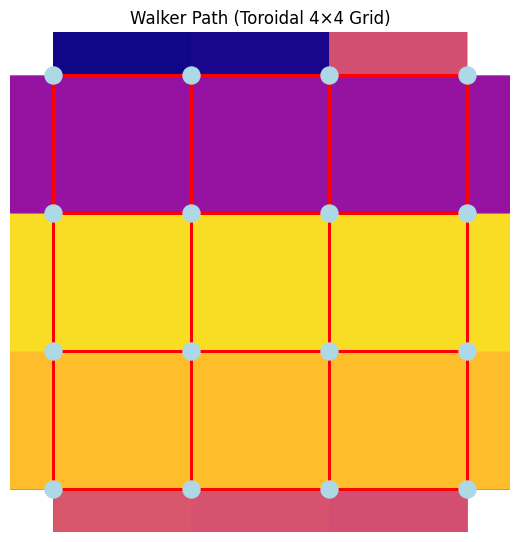

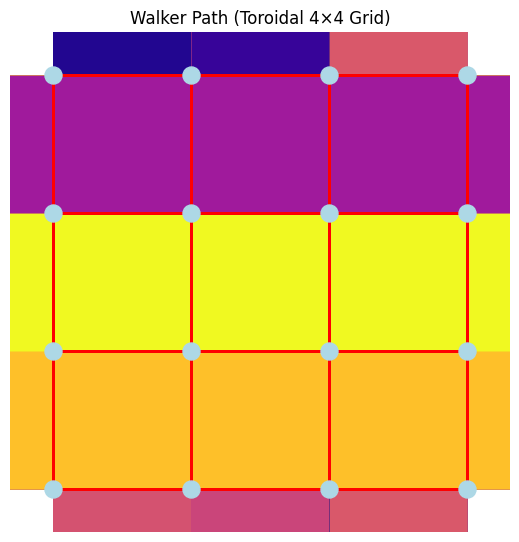


=== Spectral Fingerprint Timing Results ===
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [34]:
def benchmark_spectral_fingerprint(messages):
    """Benchmark spectral_fingerprint() for different message lengths."""
    results = []

    for msg in messages:
        start_time = time.time()
        hash_vector = spectral_fingerprint(msg)
        end_time = time.time()
        elapsed = end_time - start_time

        results.append({
            "Message": msg,
            "Length": len(msg),
            "Spectral Hash": np.round(hash_vector, 6).tolist(),
            "Time (s)": elapsed
        })

    df = pd.DataFrame(results)
    return df


# Example messages of increasing length
messages = [
    "A",
    msg87,
    msg500,
    msg1000,
    msg2_1000
]

# Run benchmark
df = benchmark_spectral_fingerprint(messages)

# ---- Display Table ----
print("\n=== Spectral Fingerprint Timing Results ===")
print(df.to_string(index=False))


**Benchmarking Graph**

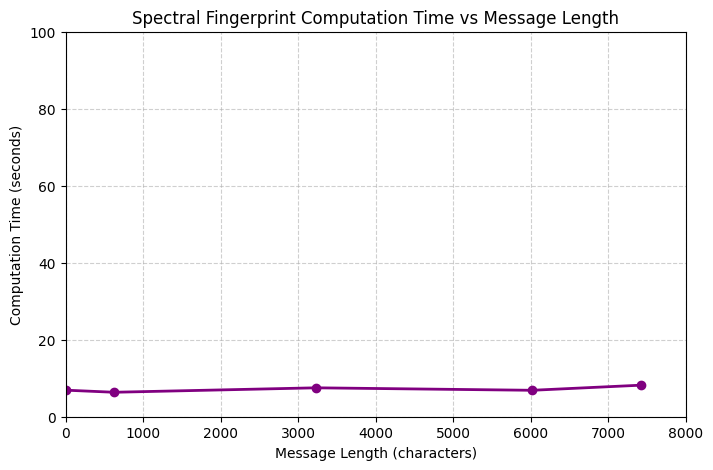

In [35]:
# ---- Plot Graph ----
plt.figure(figsize=(8, 5))
plt.plot(df["Length"], df["Time (s)"], marker='o', linewidth=2, color='purple')
plt.xlim(0, 8000)    # Fix x-axis range
plt.ylim(0, 100)
plt.title("Spectral Fingerprint Computation Time vs Message Length")
plt.xlabel("Message Length (characters)")
plt.ylabel("Computation Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Birthday Test (checking collision for 100 trails)**

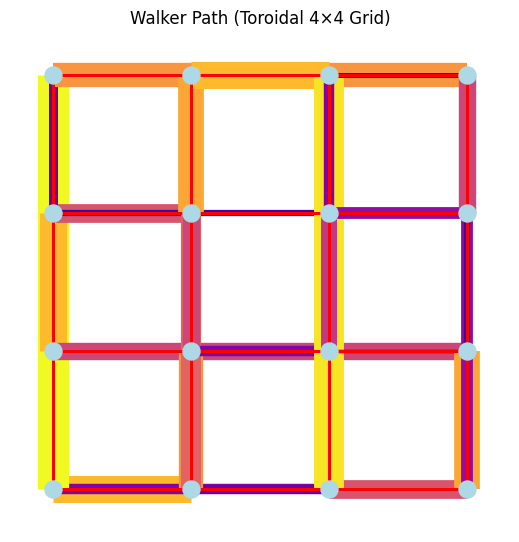

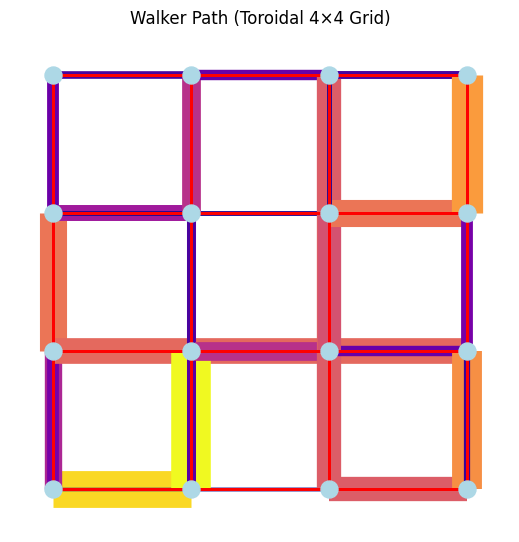

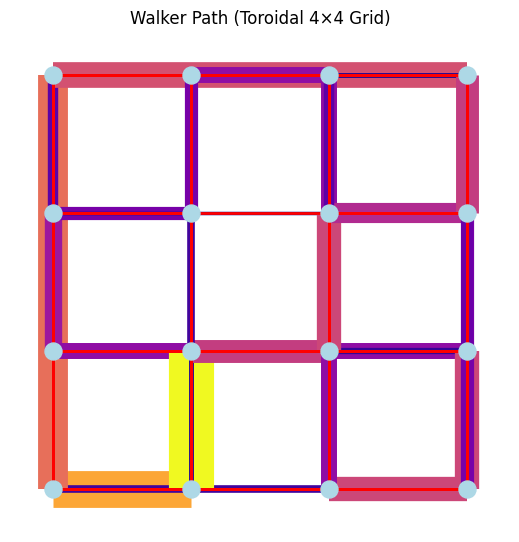

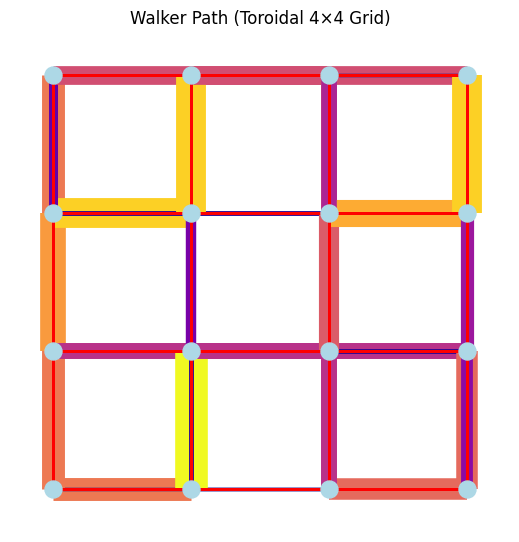

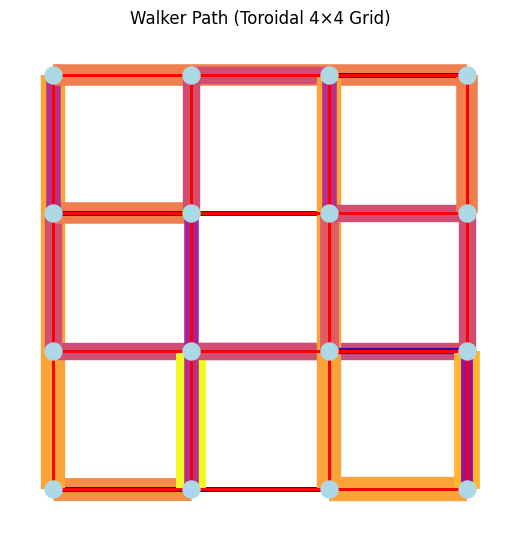

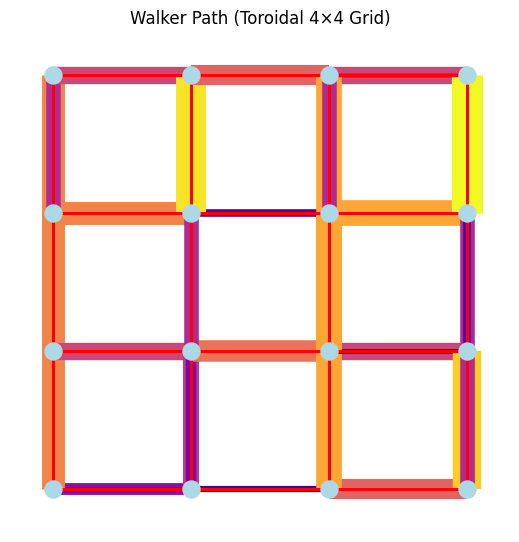

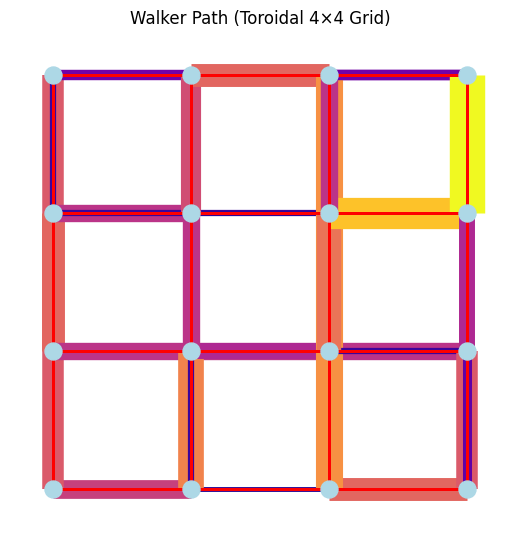

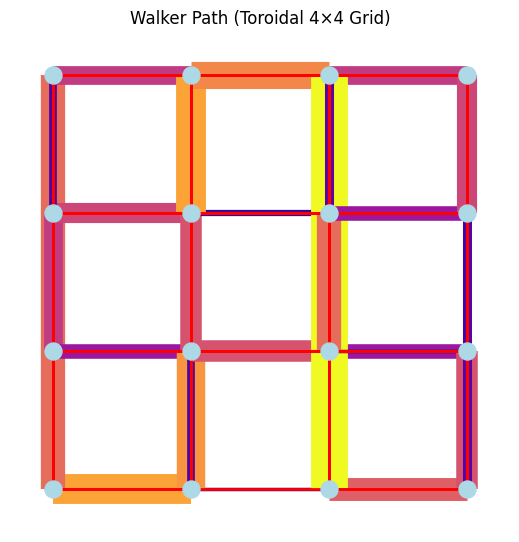

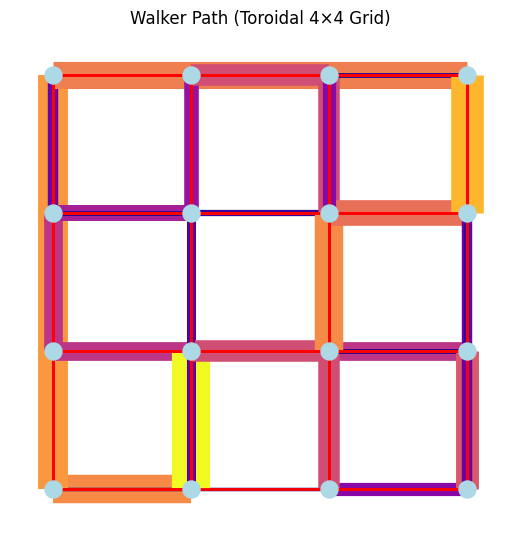

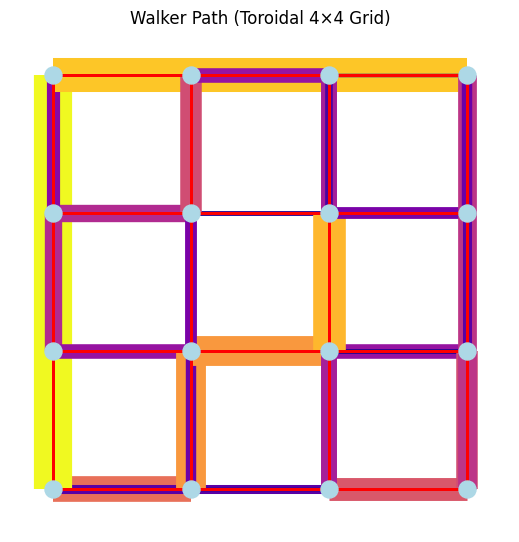

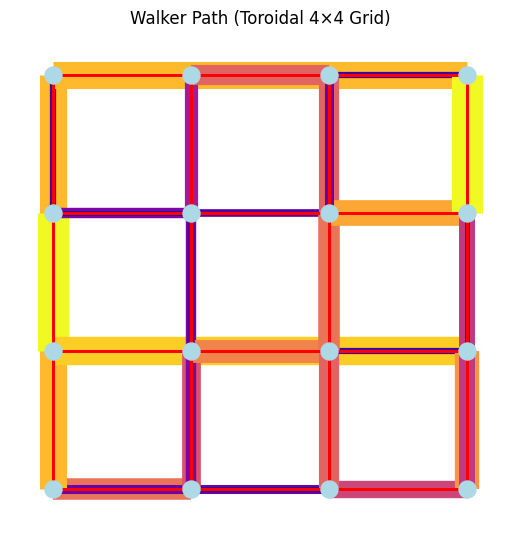

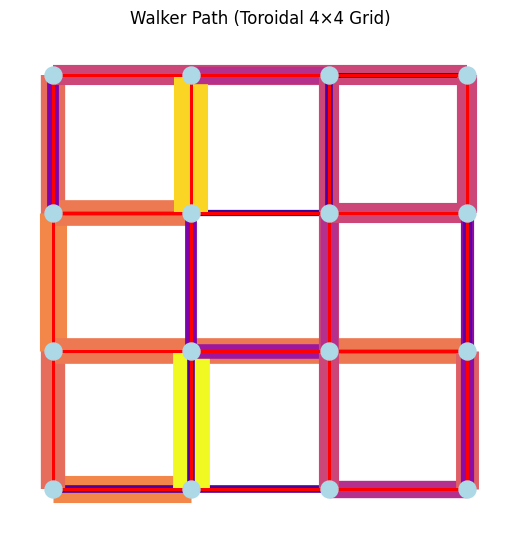

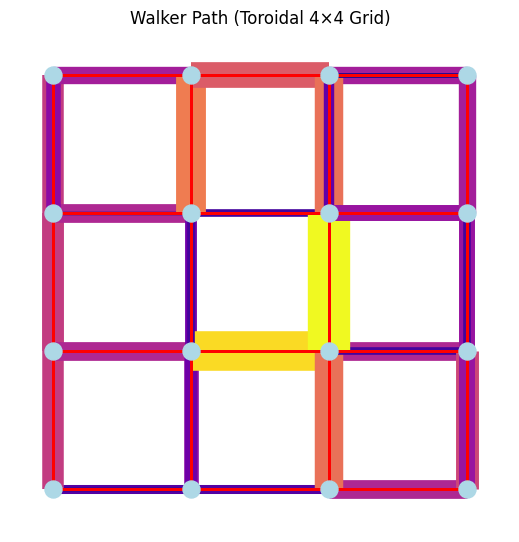

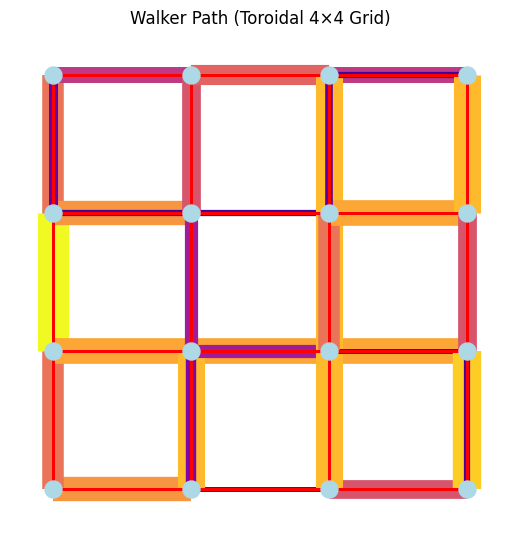

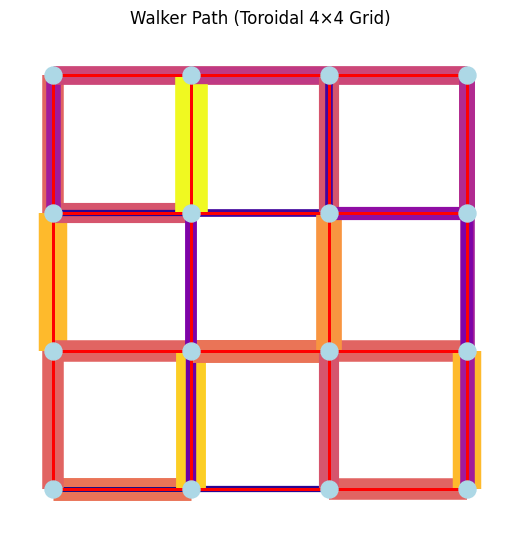

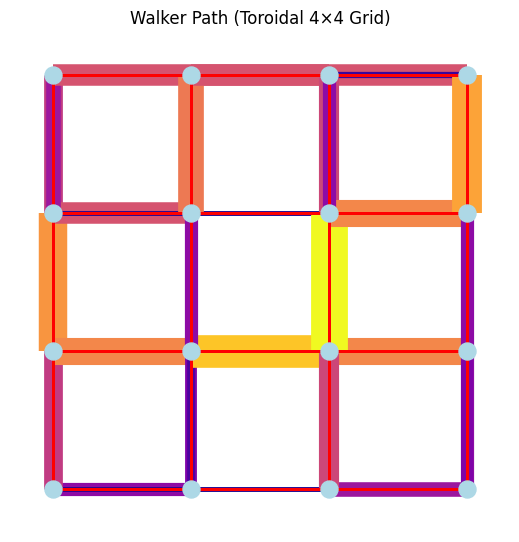

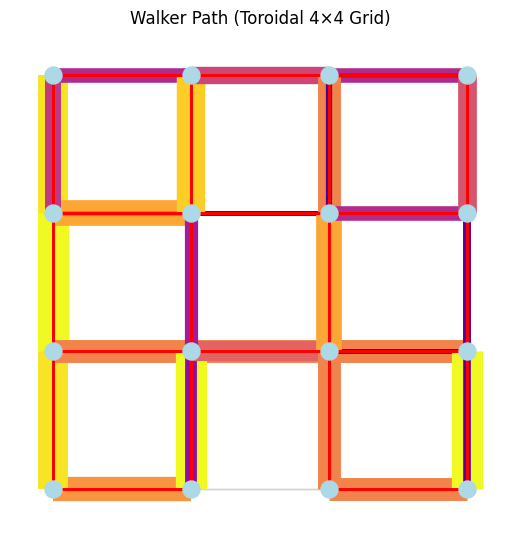

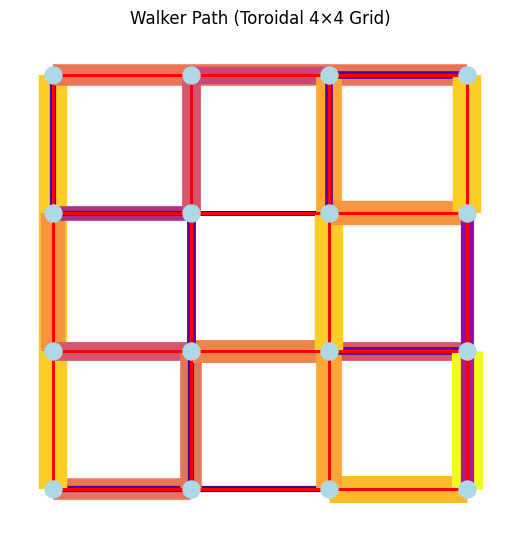

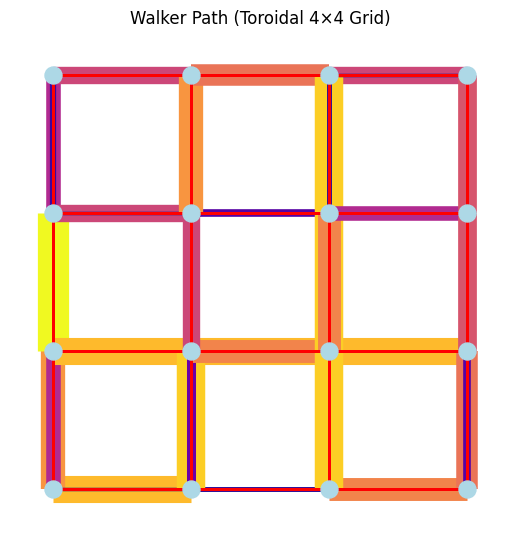

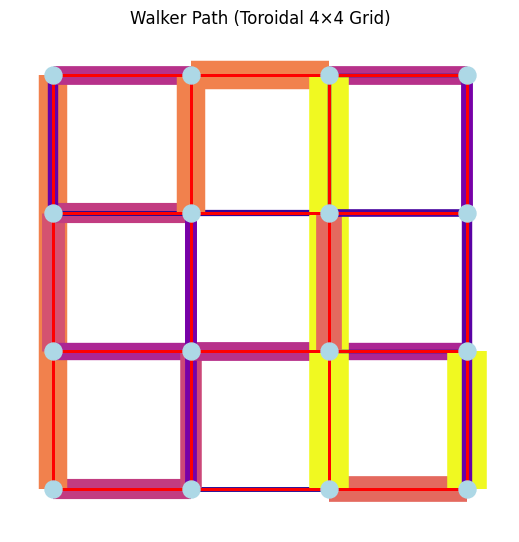

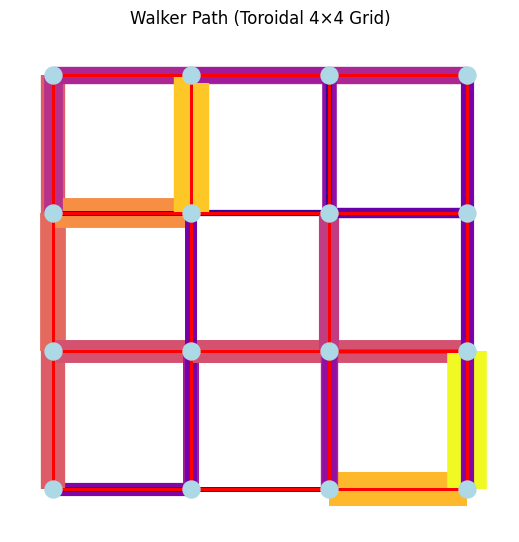

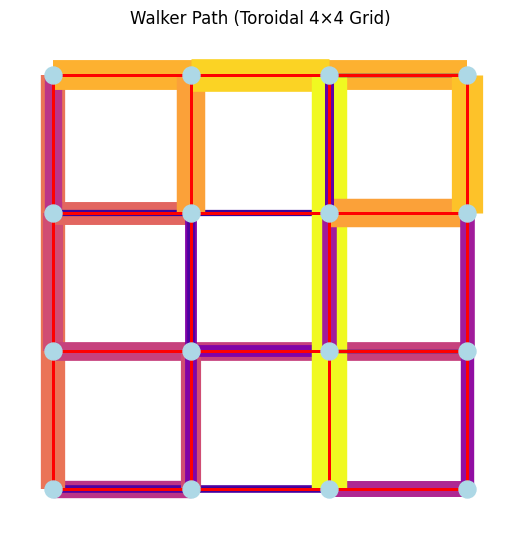

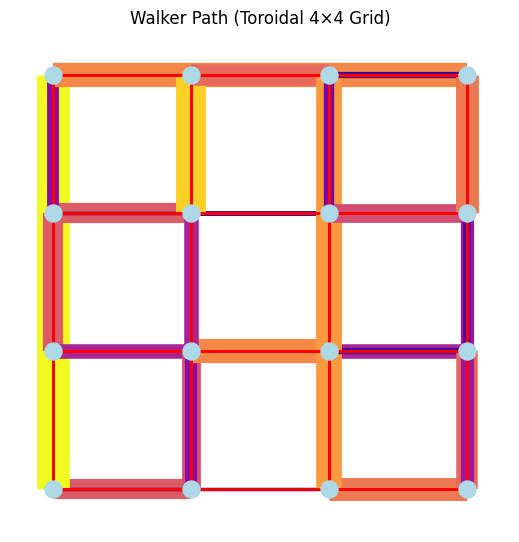

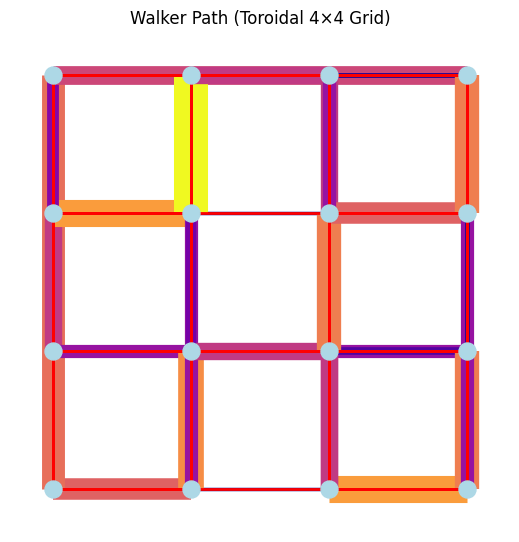

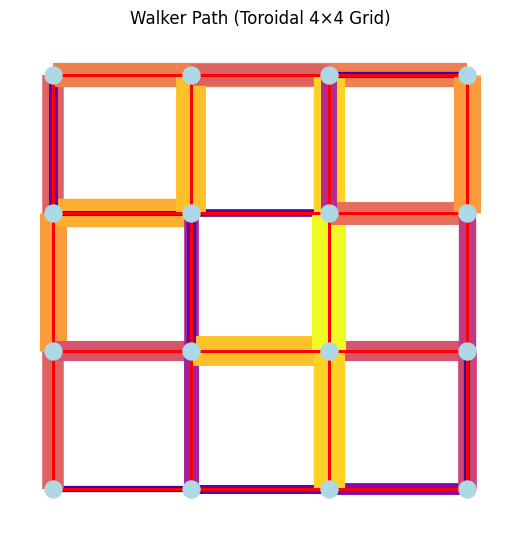

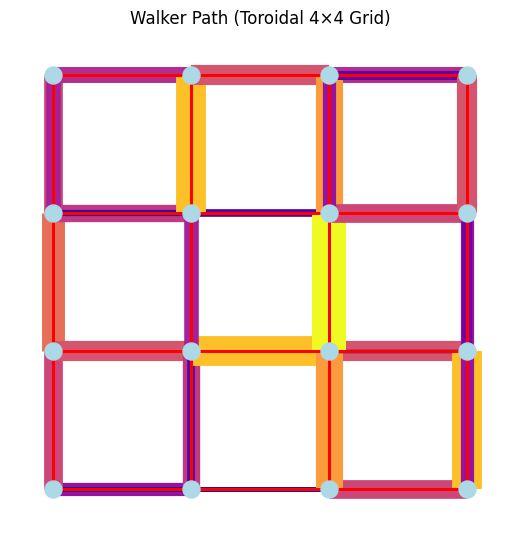

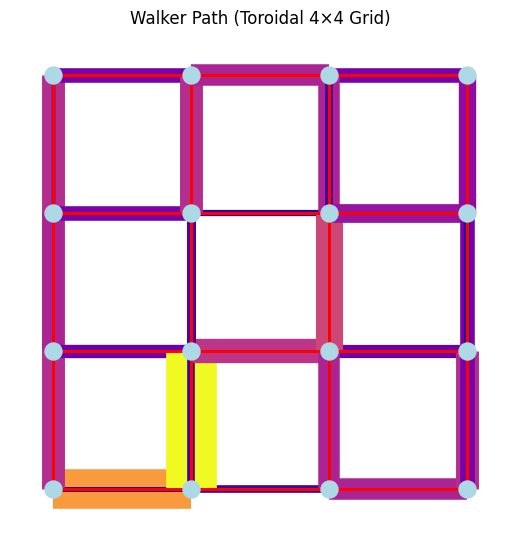

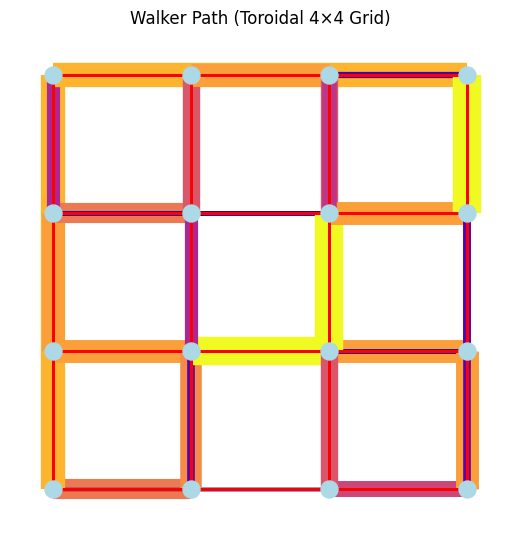

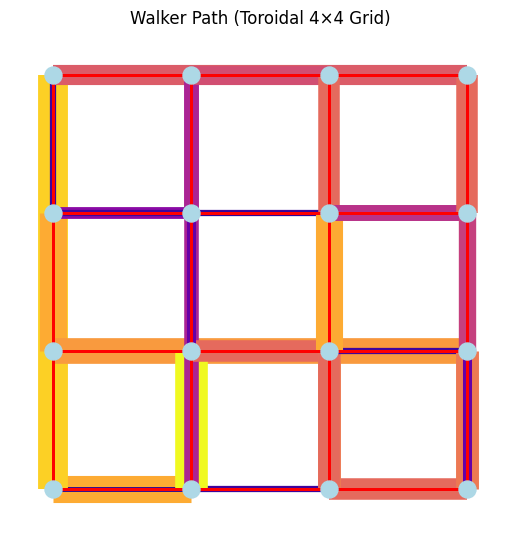

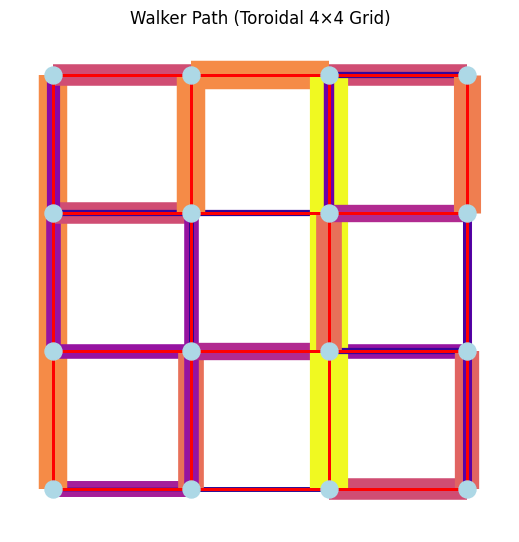

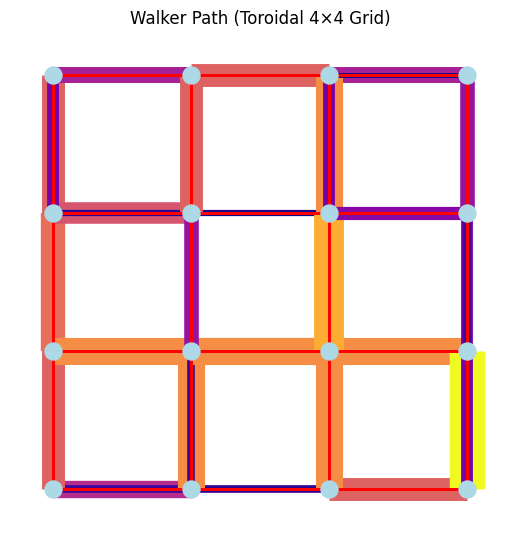

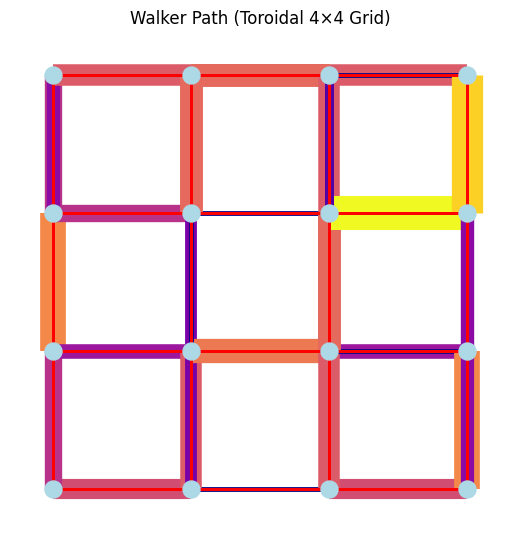

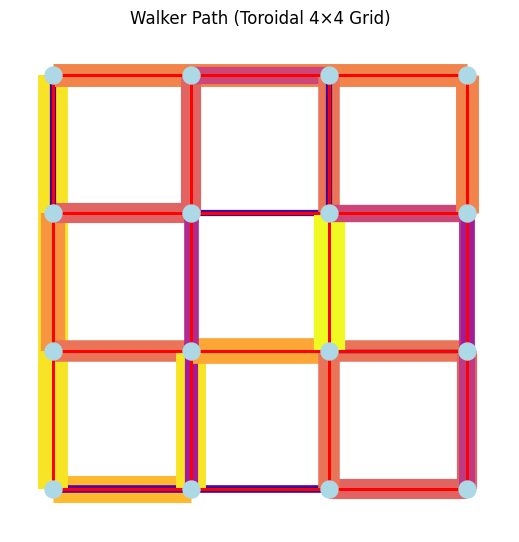

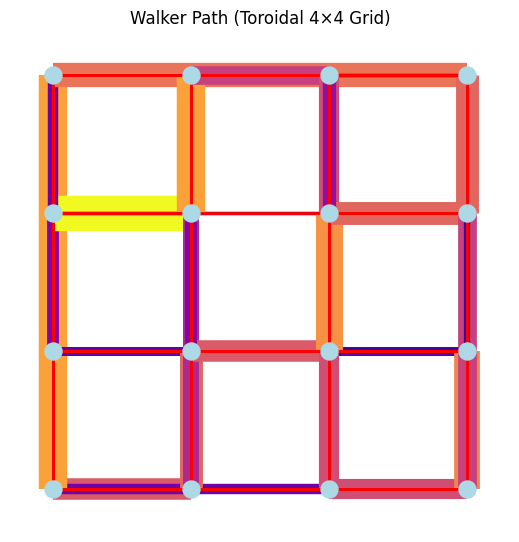

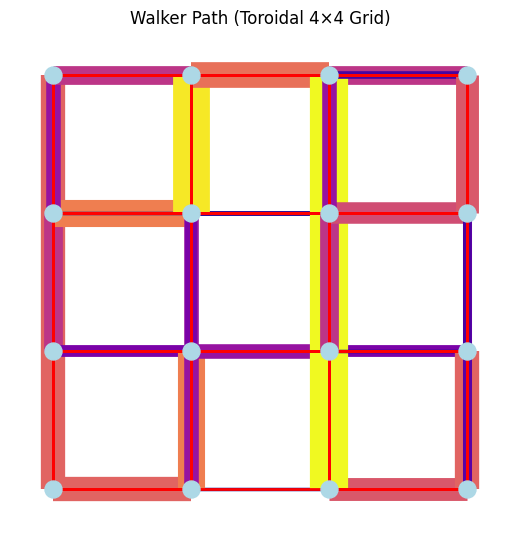

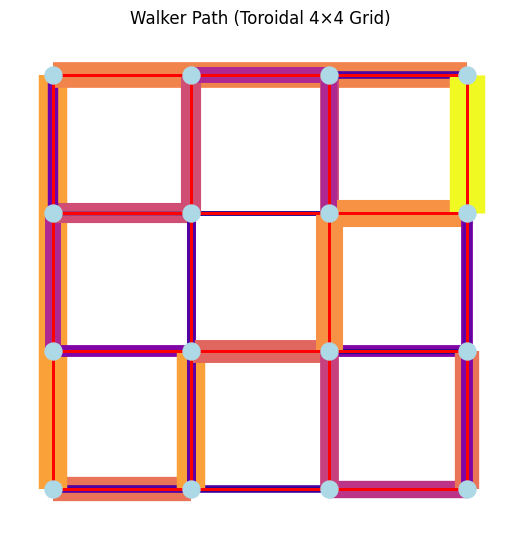

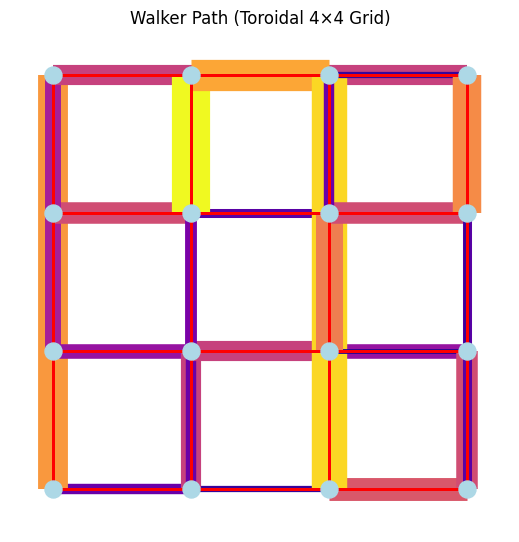

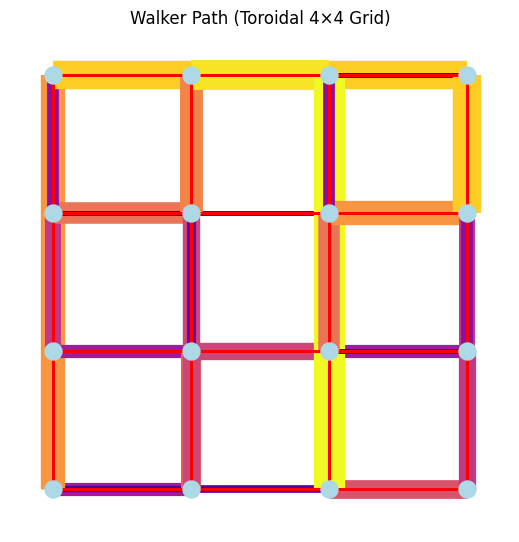

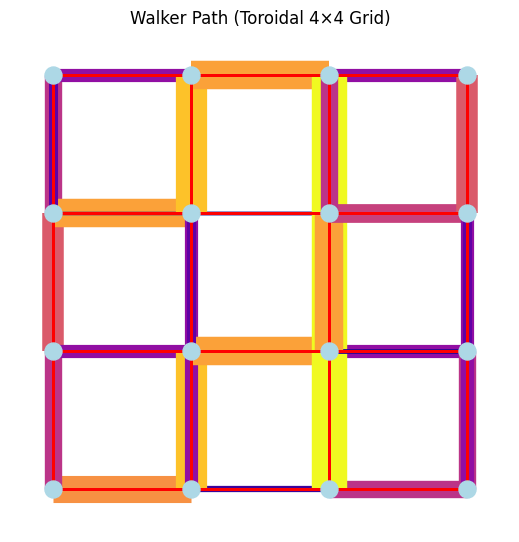

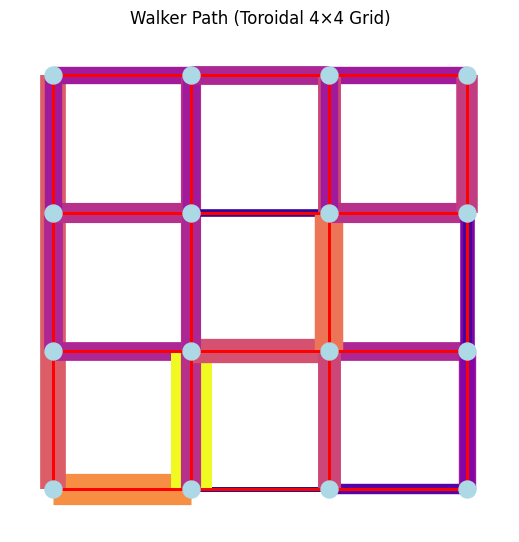

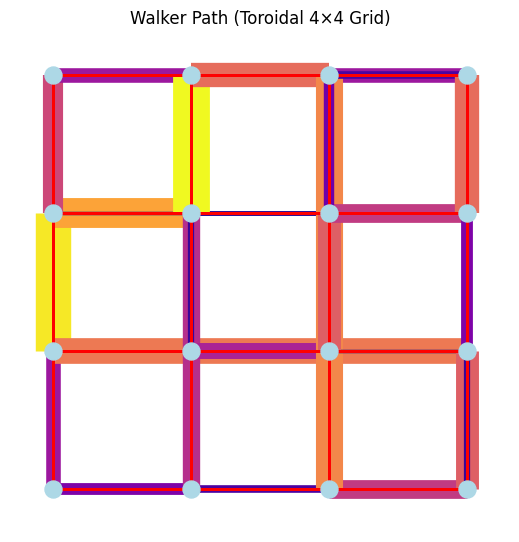

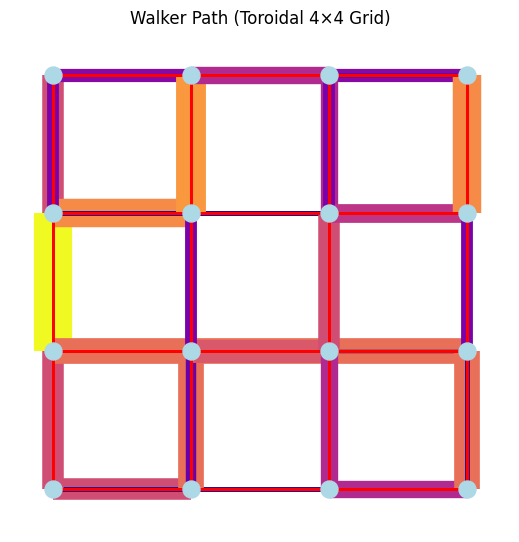

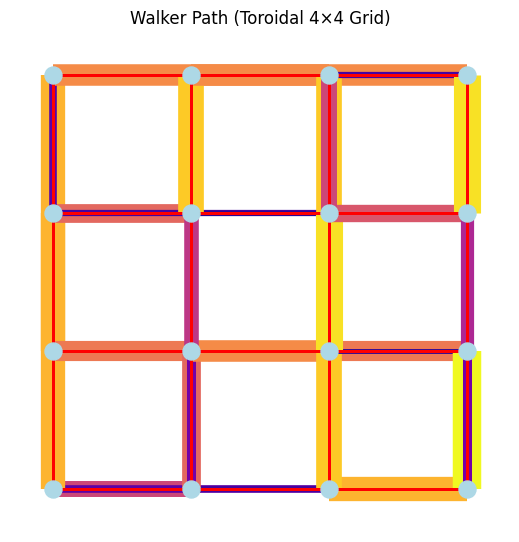

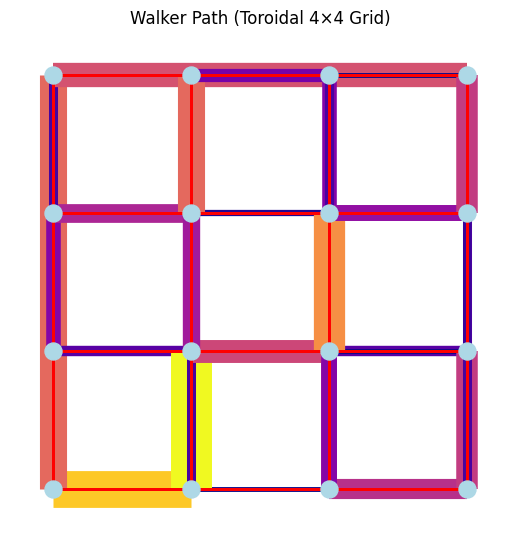

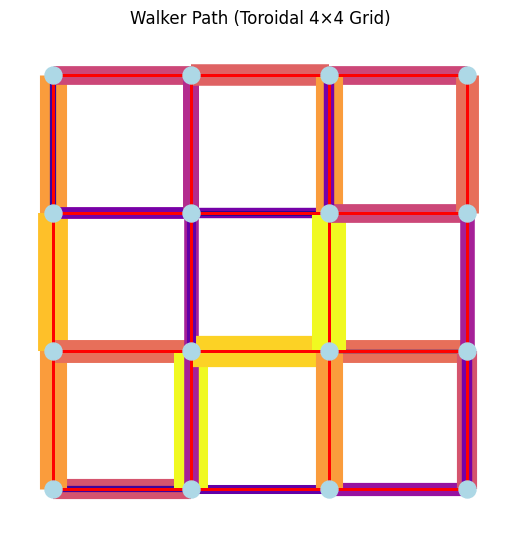

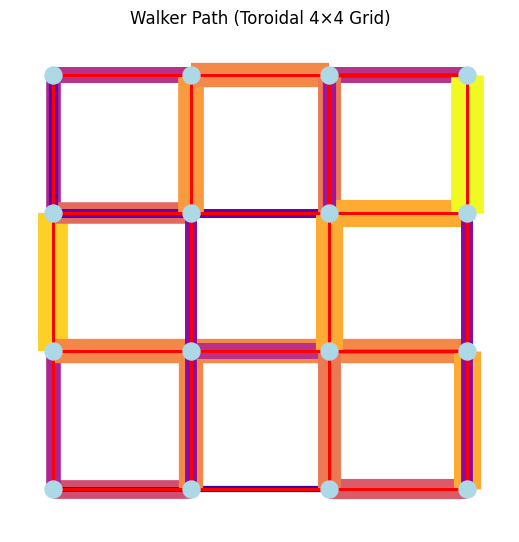

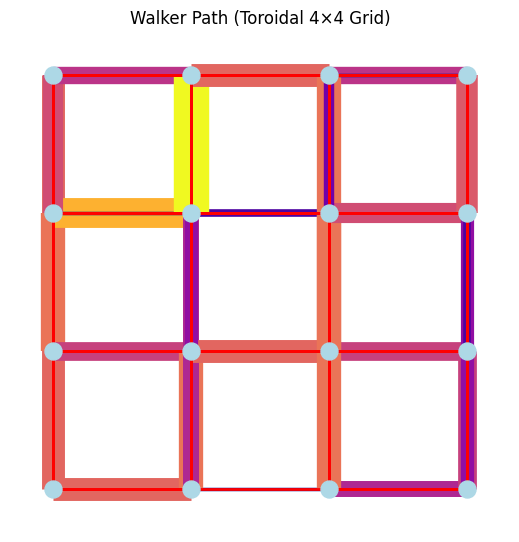

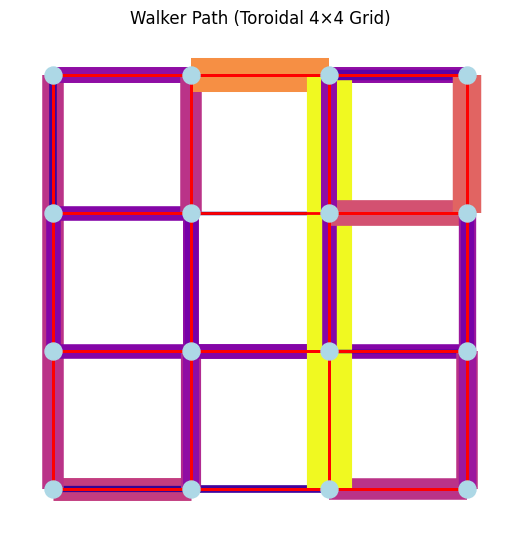

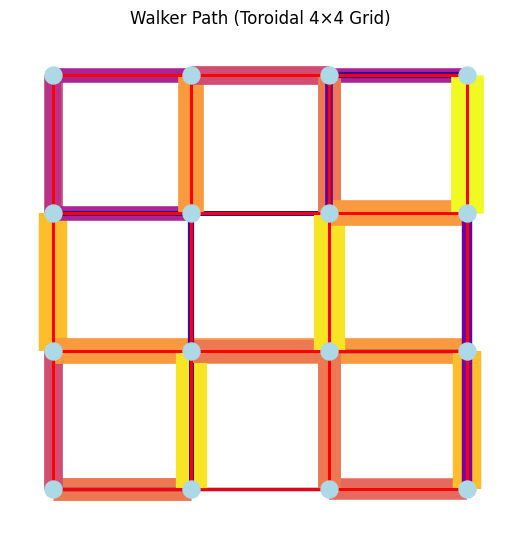

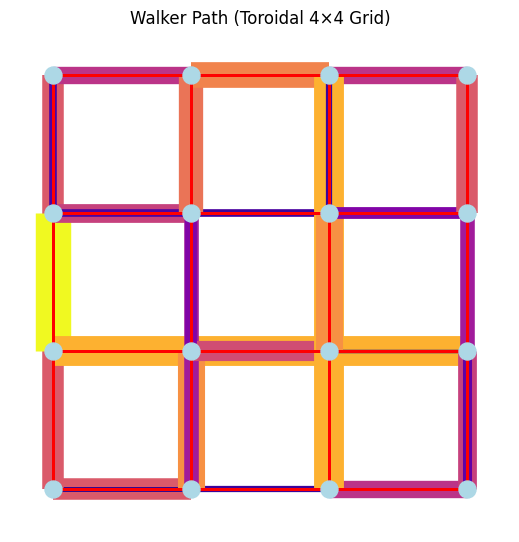

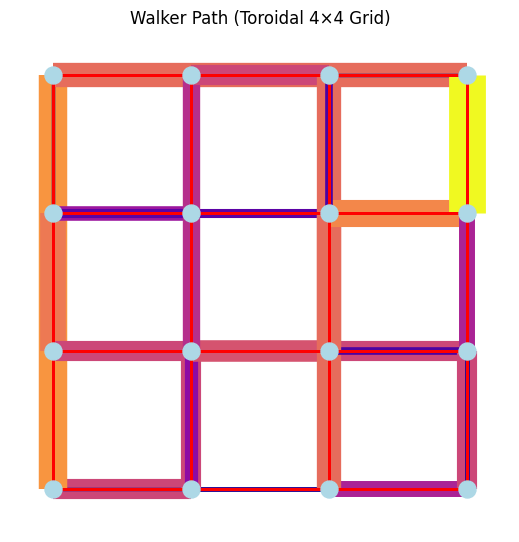

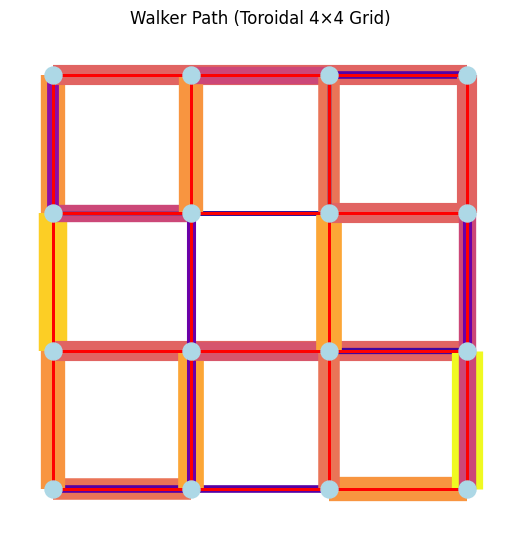

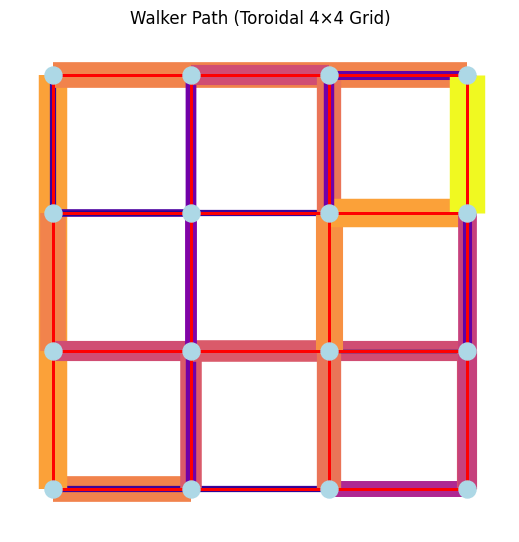

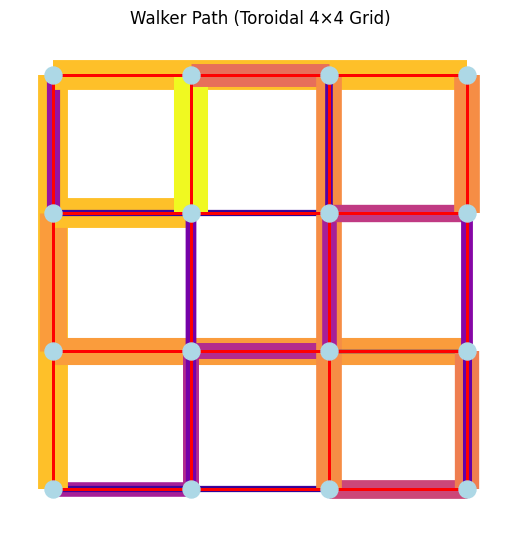

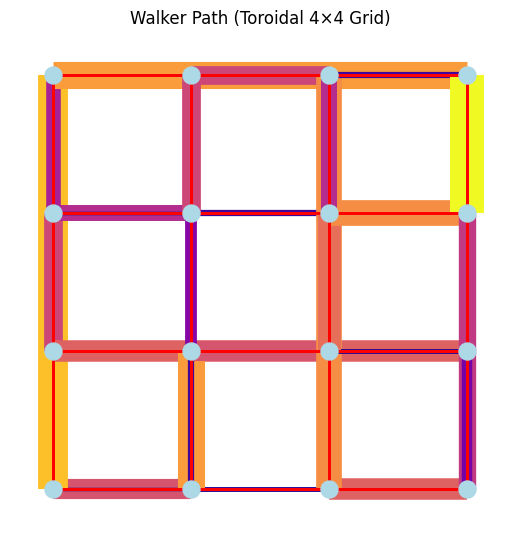

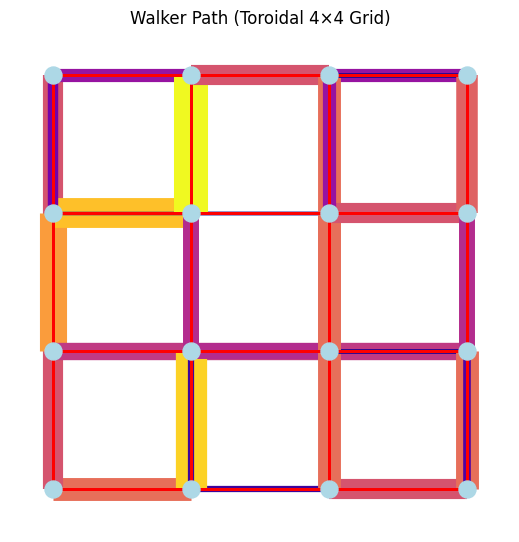

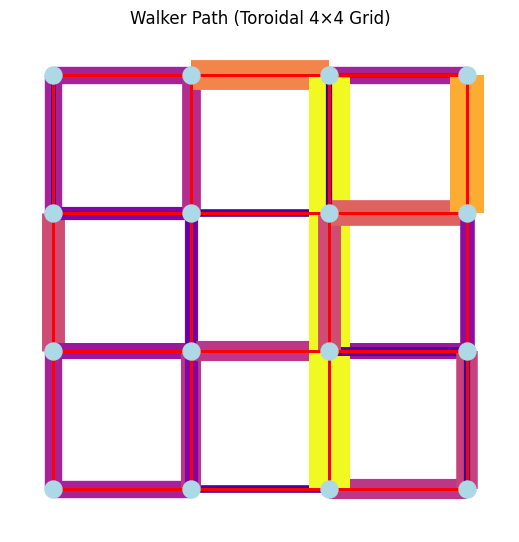

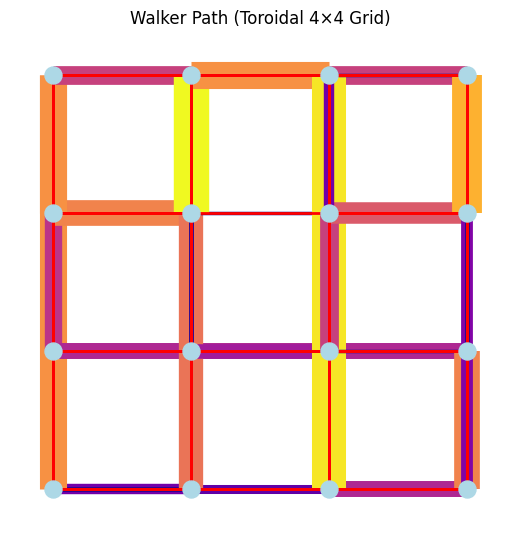

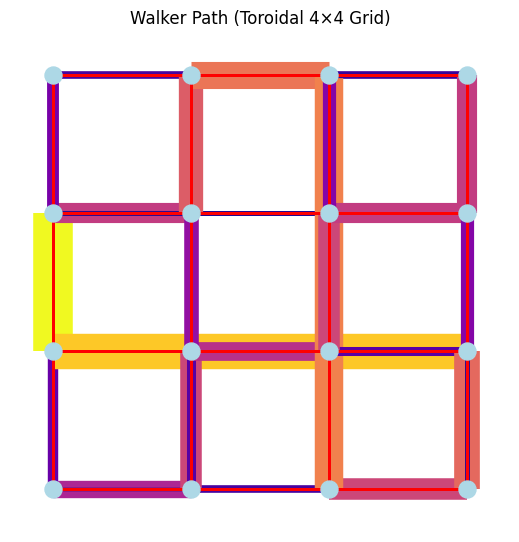

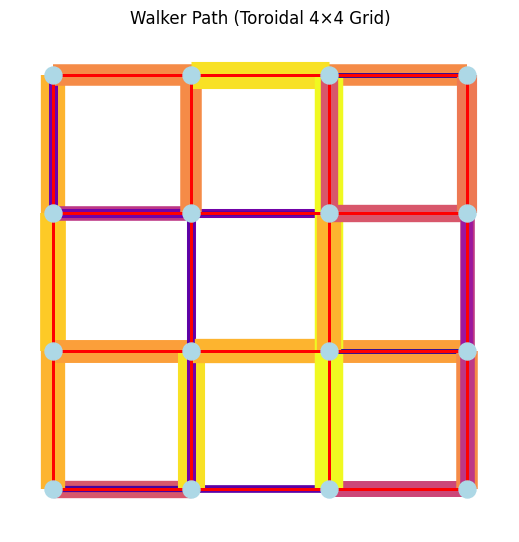

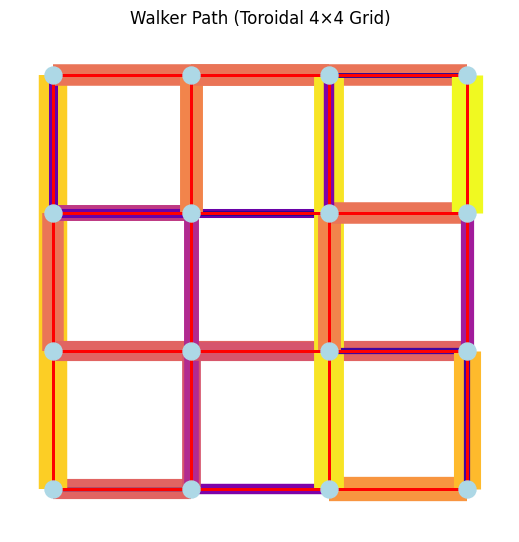

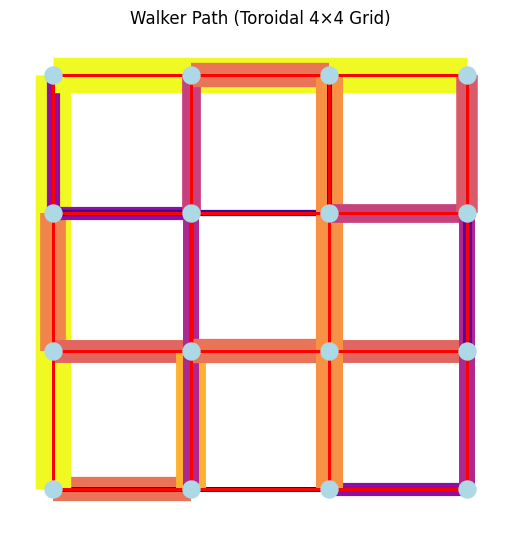

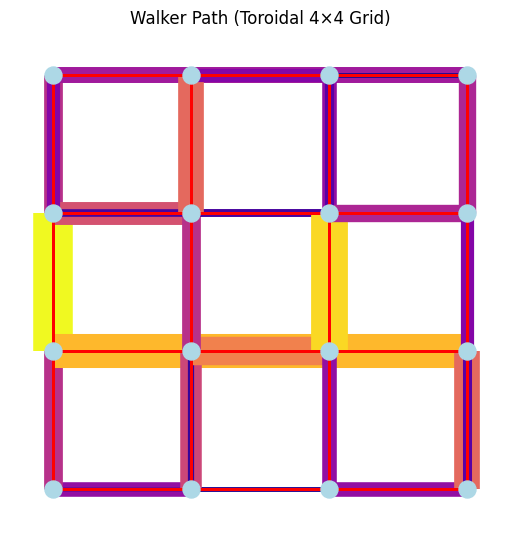

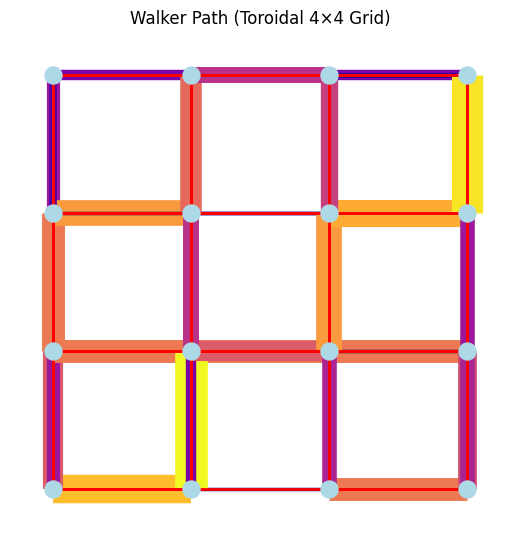

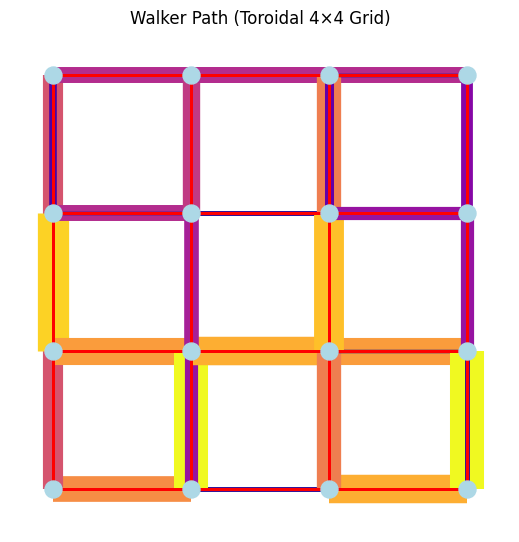

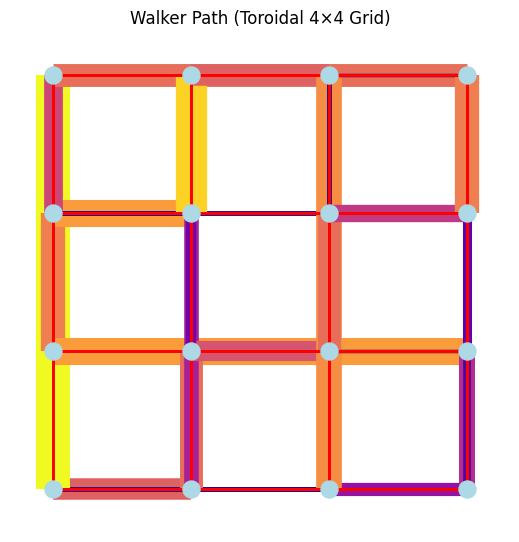

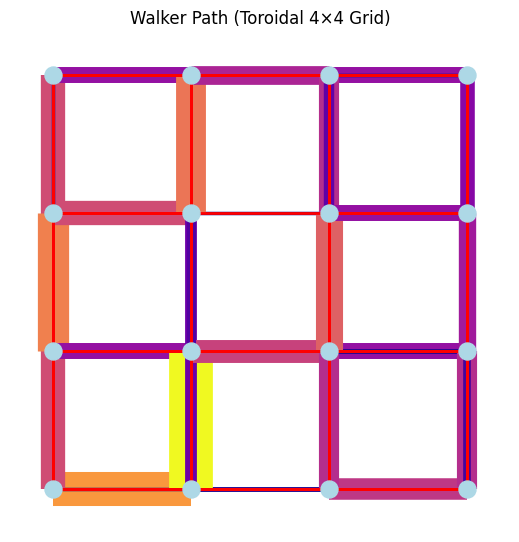

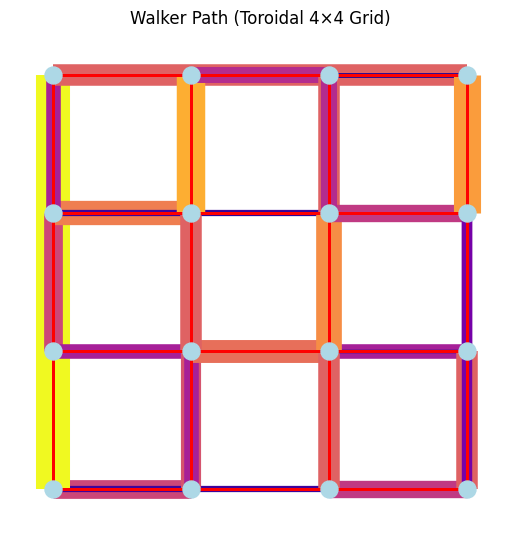

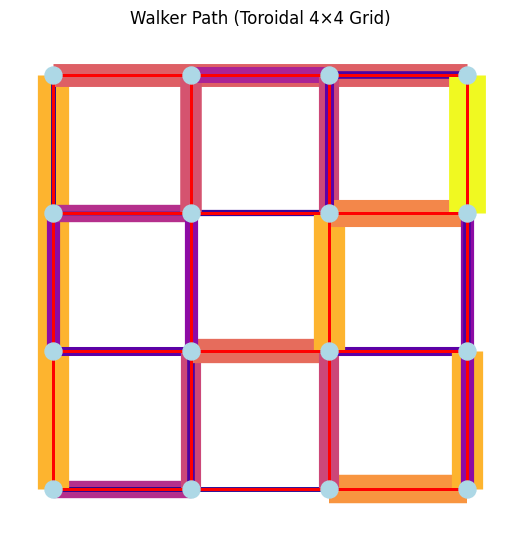

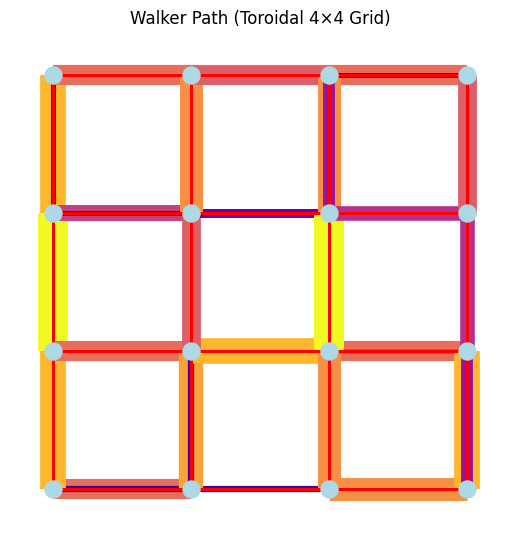

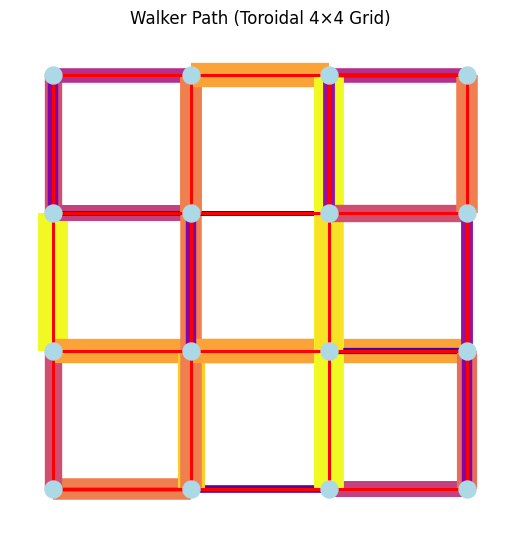

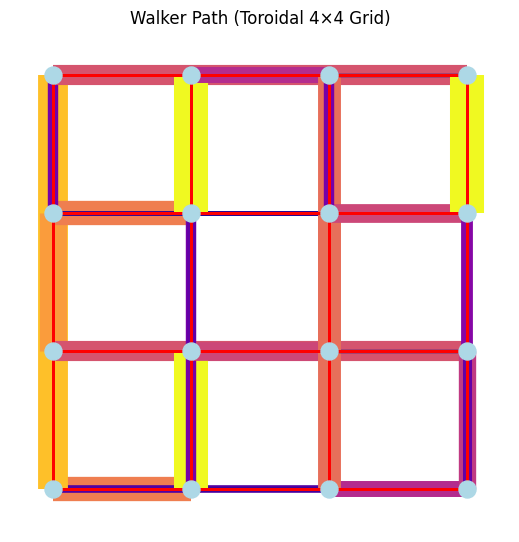

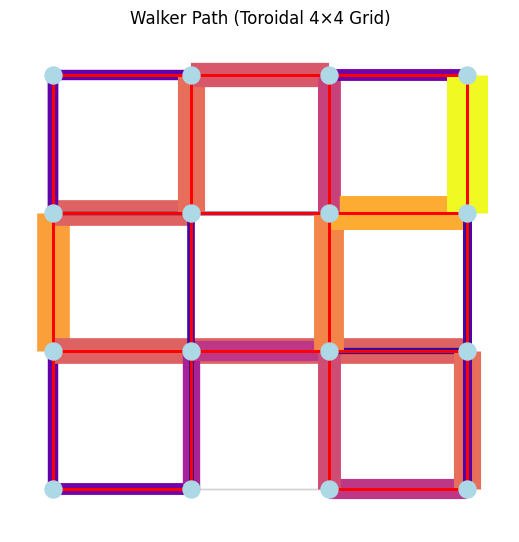

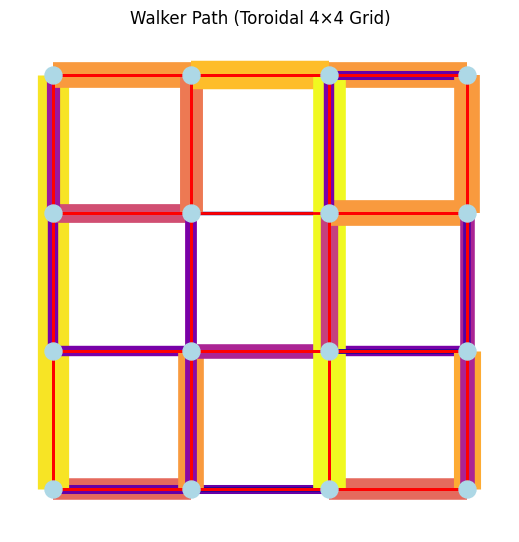

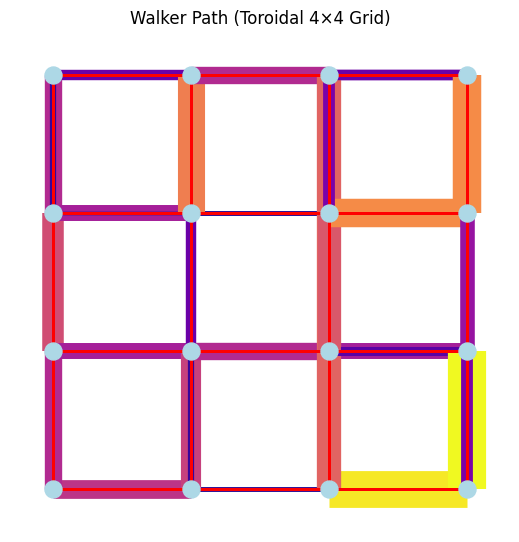

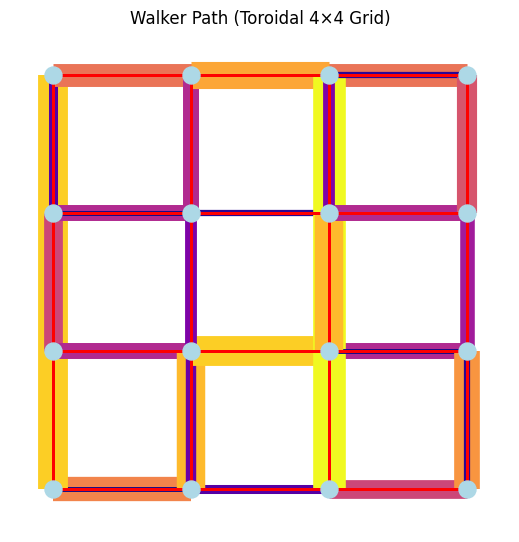

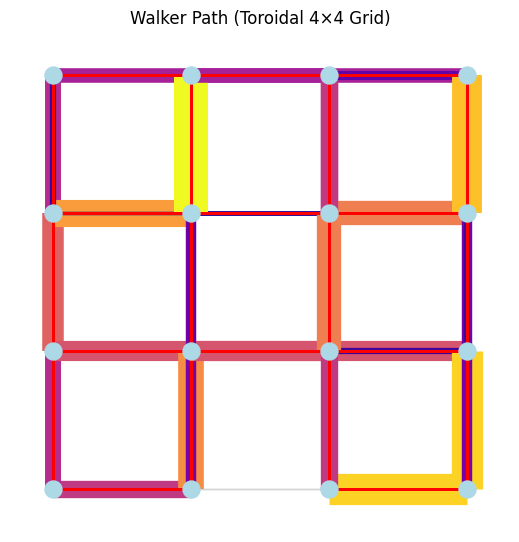

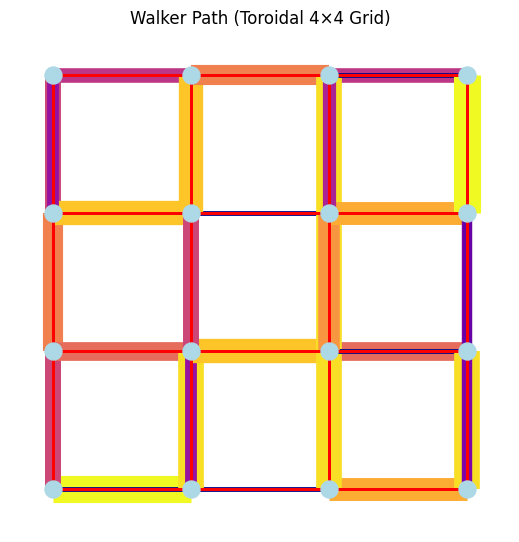

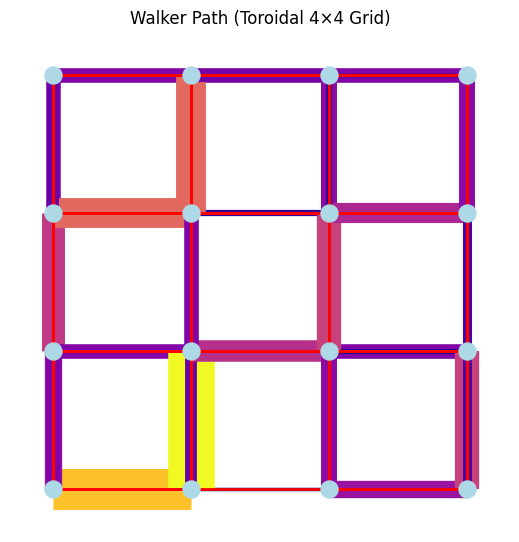

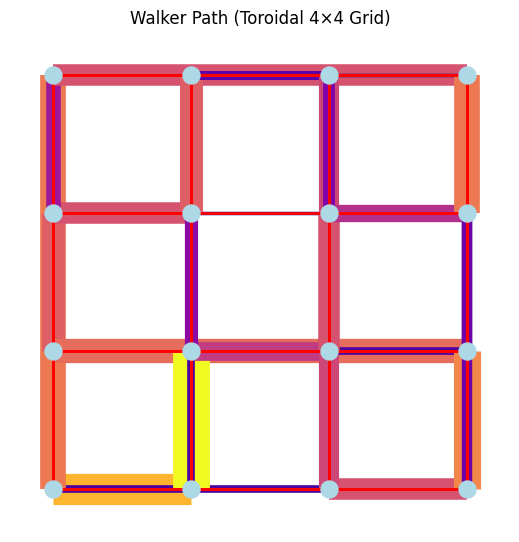

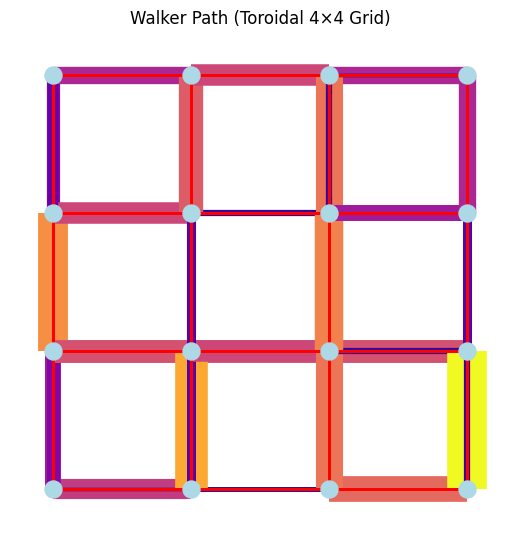

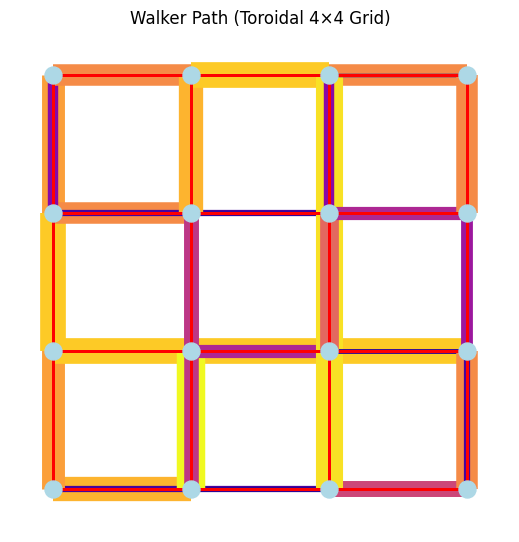

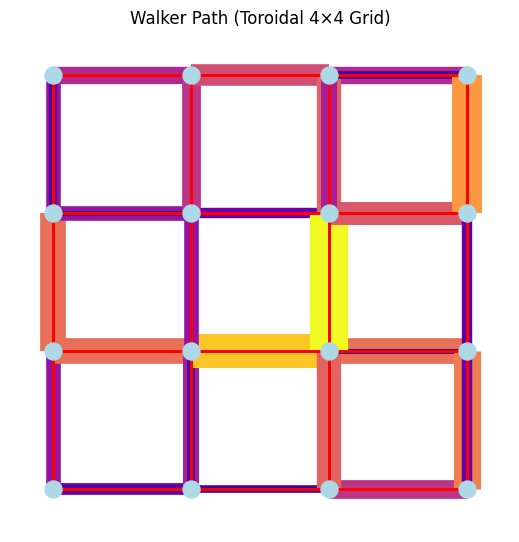

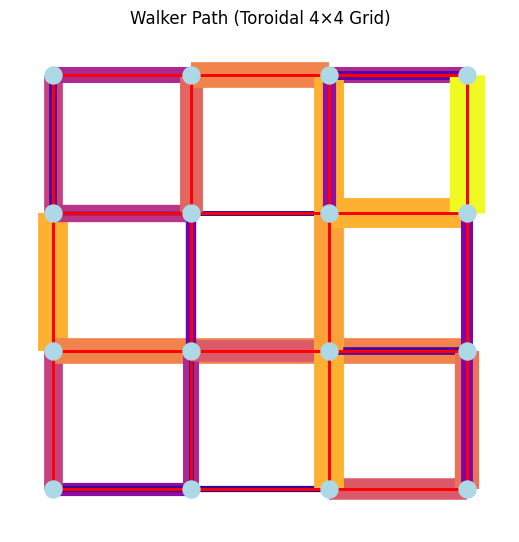

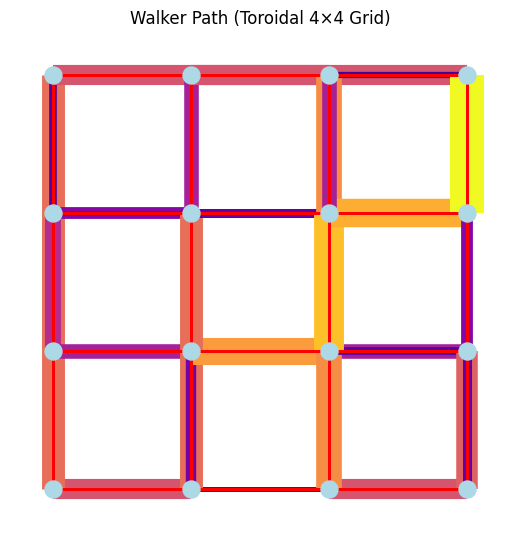

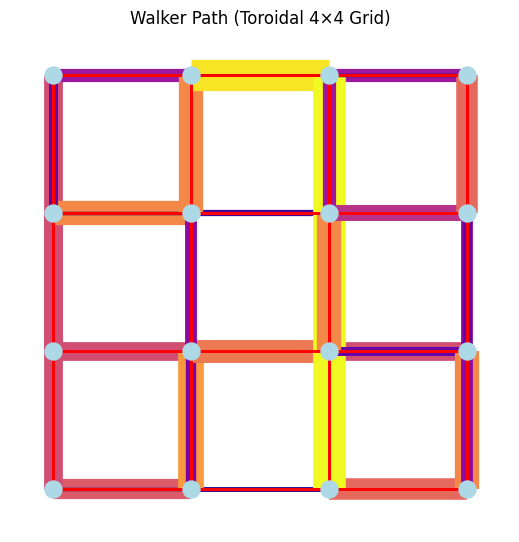

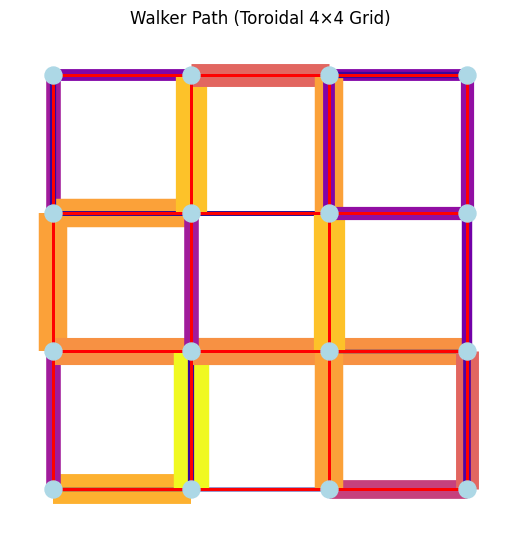

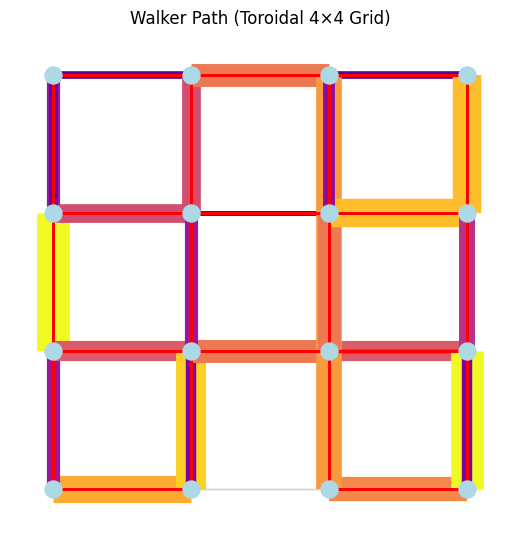

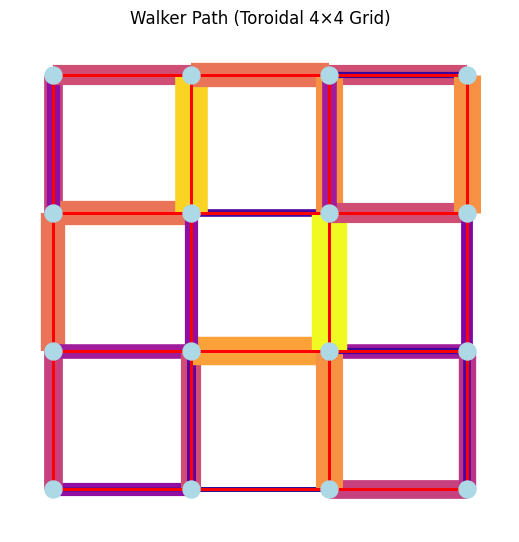

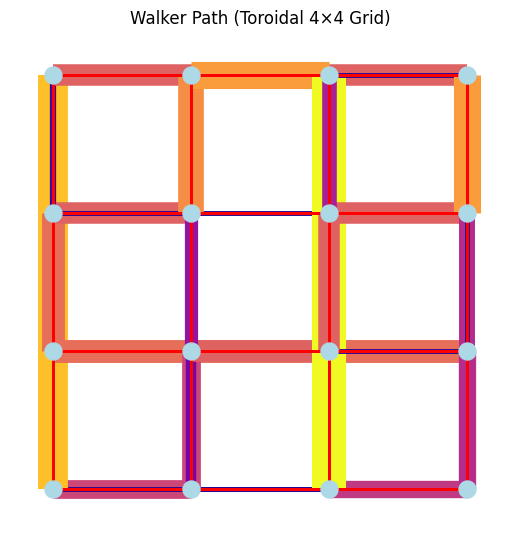

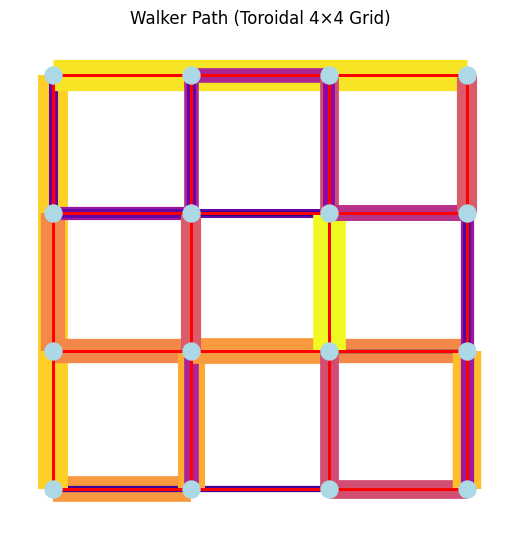

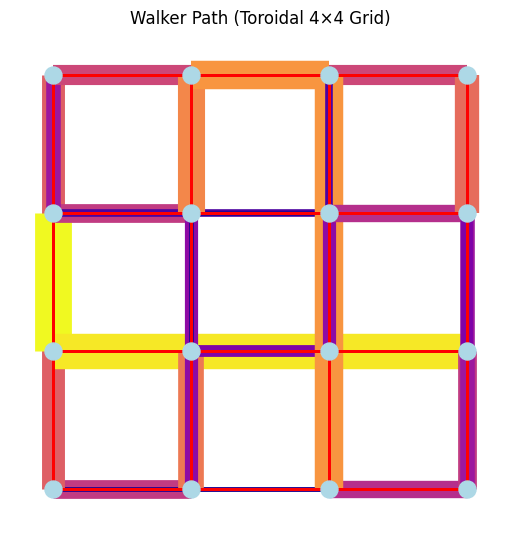

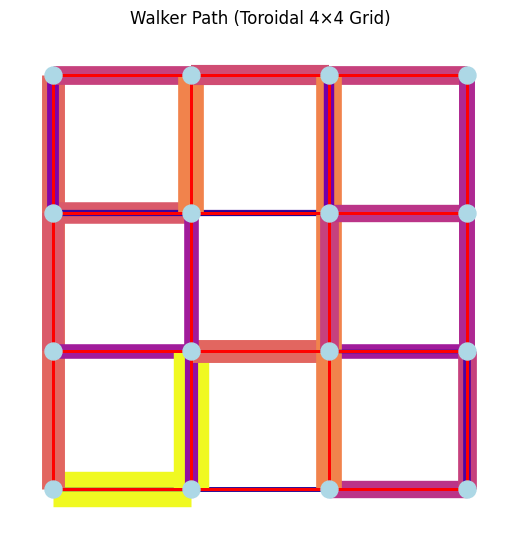

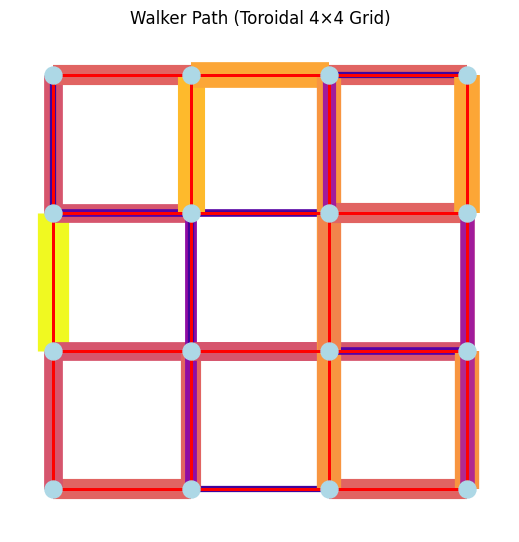

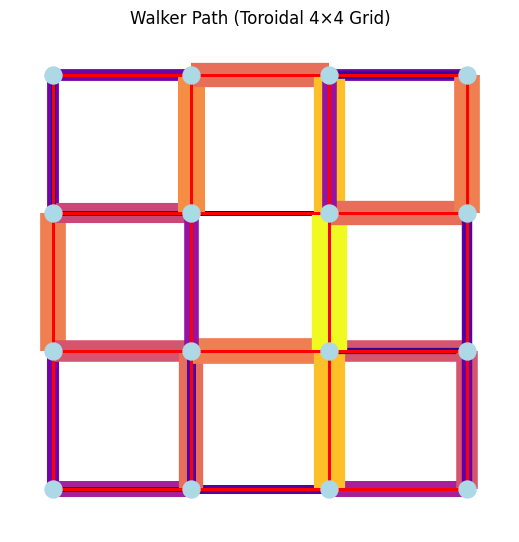

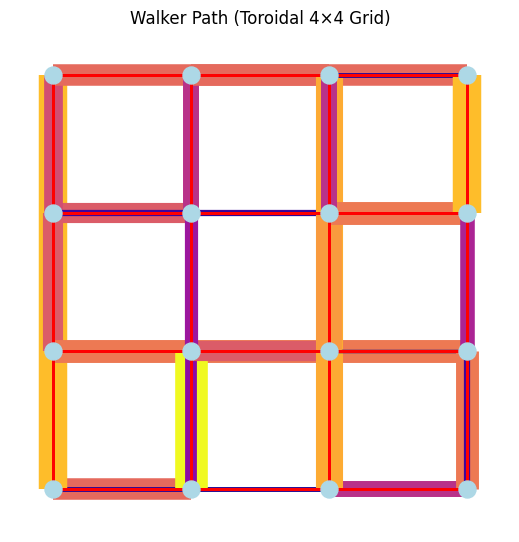

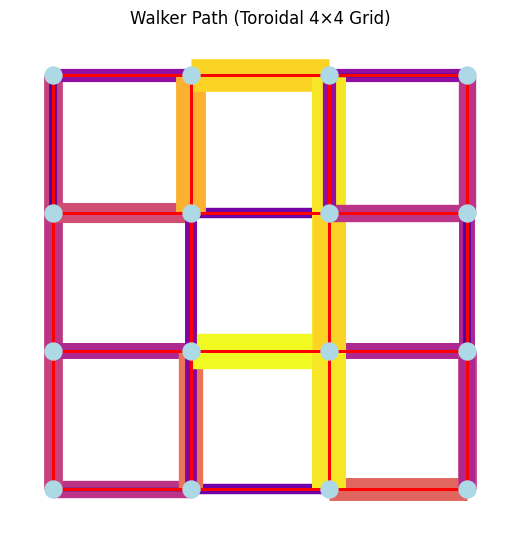

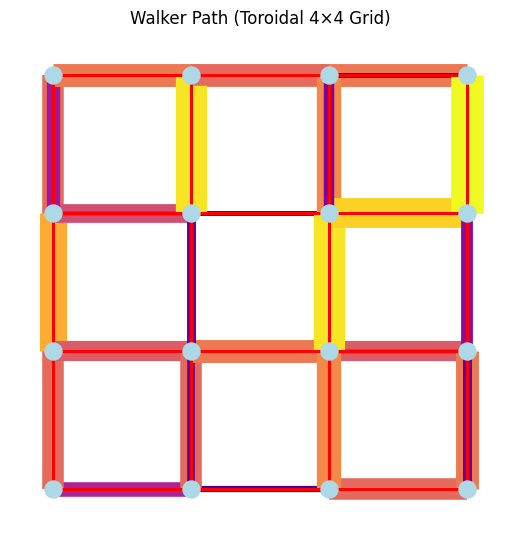

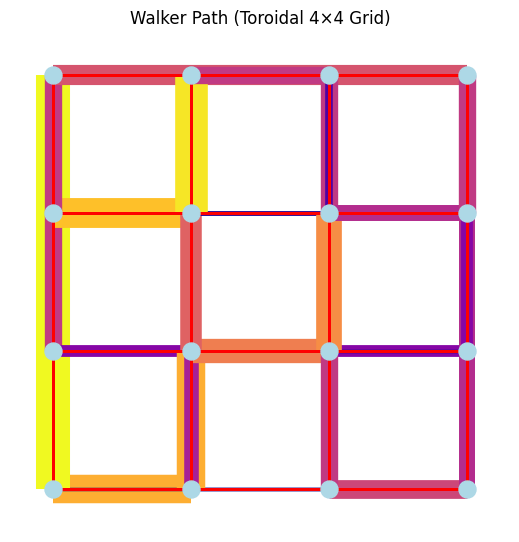

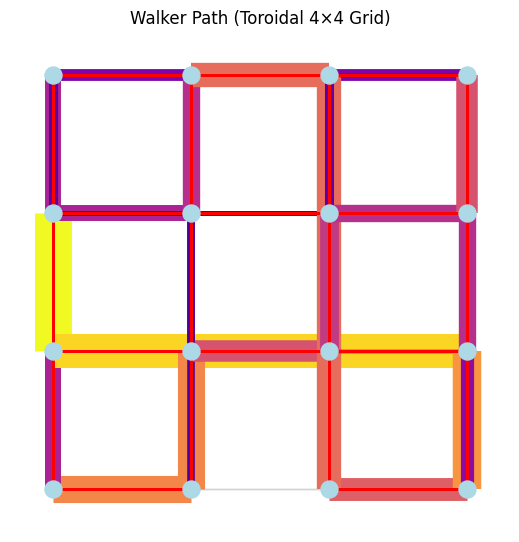

No collision found after 100 trials.


In [39]:
import random

def test_birthday_collision(max_trials=100):
    hashes = set()

    for i in range(max_trials):
        # Generate a random input message
        message = str(random.getrandbits(256))

        # --- Use your custom spectral fingerprint hash ---
        sf = spectral_fingerprint(message)
        h = convert_spectral_fingerprint_into_hash(sf)

        # --- Check for collision ---
        if h in hashes:
            print(f"Collision found after {i} hashes!")
            return i
        hashes.add(h)

    print(f"No collision found after {max_trials} trials.")
    return None

test_birthday_collision()